In [1]:
import csv
import sklearn
import pandas
import numpy as np
from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot
from pandas import datetime as p_datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from pandas.tools.plotting import autocorrelation_plot
%matplotlib inline 

## Constants

In [2]:
STATION_ID_COL_NAME = 'station id'
STATION_NAME_COL_NAME = 'station name'
PARAM_T = 'T [°C]'
PARAM_RAIN = 'količina padavin [mm]'

## Helper Functions

In [3]:
def ARSO_datetime_to_epoch(datetime_string):
    """Convert ARSO datetime into epoch time in seconds."""
    try:
        utc_time = datetime.strptime(datetime_string, "%Y-%m-%d %H:%M")
    except:
        utc_time = datetime.strptime(datetime_string, "%Y-%m-%d")
    epoch_time = (utc_time - datetime(1970, 1, 1)).total_seconds()
    return epoch_time


def ARSO_datetime_to_epoch_array(datetime_strings):
    """Convert list of ARSO datetimes into epoch time in seconds."""
    return [ARSO_datetime_to_epoch(dt) for dt in datetime_strings]


def synchronize_date(date_string):
    """Convert datetime into common form using dots."""
    date_string = date_string.replace('/', '.')
    date_string = date_string.replace('-', '.')
    date_string = date_string.replace('Feb', '2')
    return date_string

def synchronize_time(time_string):
    time_string = time_string.replace(':00', '')
    return time_string

def borzen_datetime_to_datetime(datetime_string):
    """Convert borzen datetime in string into datetime object."""
    # synchronize all dates
    tmp = datetime_string.split(" ")
    date = tmp[0]
    if len(date) < 6: # Example 1.1.02
        print("Error in date parsing " + date + " in datetime " + datetime_string)
        return
    time = tmp[-1]
    if len(date) < 1: # Example 1
        print("Error in time parsing " + time + " in datetime " + datetime_string)
        return
    date = synchronize_date(date)
    time = synchronize_time(time)
    datetime_string = date + " " + time
    # convert to epoch
    try:
        utc_time = datetime.strptime(datetime_string, "%d.%m.%Y %H")
        return utc_time
    except:
        # strptime accepts [0,23] hour interval, while borzen data has [1,24] hour 
        # interval, thus modification of '24' into '00' is needed
        if datetime_string[-2:] == "24":
            datetime_string = datetime_string[:-2] + "00"
            utc_time = datetime.strptime(datetime_string, "%d.%m.%Y %H")
            return utc_time
        else:
            print("Error in datetime parsing: " + datetime_string)

def datetime_to_epoch(datetime_):
    """Convert borzen datetime into epoch time in seconds."""
    epoch_time = (datetime_ - datetime(1970, 1, 1)).total_seconds()
    return epoch_time

def plot_true_and_pred(model, P, true, plot=True, from_=0, to_=2000):
    """Plot true and predicted values and print MSE."""
    # predict
    pred = model.predict(P)
    # plot
    if plot:
        plot_raw_and_predicted(true, pred, from_, to_)
    # print error
    print("Loss: " + str(loss(true, pred)))

## Classes

In [4]:
class Station:
    """Holds all informations about weather station."""
    def __init__(self, station_id, station_name, header, data, data_timestamp_epoch):
        self.station_is = station_id
        self.station_name = station_name
        self.header = header
        self.data = data
        self.size = len(data)
        self.data_ts = data_timestamp_epoch
    
    def __str__(self):
        return self.station_id + " " + self.station_name + " size=" + str(self.size)
    
    def __repr(self):
        return self.station_id + " " + self.station_name + " size=" + str(self.size)

In [5]:
class Prices:
    """Holds prices and corresponding timestamps."""
    def __init__(self, prices, prices_timestamp_epoch):
        self.prices = prices
        self.timestamps = prices_timestamp_epoch

## Load Data Functions

In [6]:
def test_load_ksedlo():
    """Load weather data for Korenjsko sedlo that has been dowloaded 
    from ARSO website. It removes lines that have any NaN values."""
    print('Start loading korenjsko sedlo')
    test_file_ksedlo = '/Users/ales/Desktop/STUDIJ/DodatnoLeto/' \
                        'MatematikaZracunalnikom/WeatherDataTest/KorenjskoSedloTest'
    # open file and read content in a csv format
    csvfile = open(test_file_ksedlo, 'r')
    reader = csv.reader(csvfile, delimiter=',')
    data = list(reader)
    # extract header and clean up data by removing empty lines
    header_line = [el.strip() for el in data[0]]
    station_id = header_line[0]
    station_name = header_line[1]
    header = header_line[2:]
    # there are empty lines generated by parsing that needs to be removed
    data_full = data[2:len(data):2]
    data_empty = data[1:len(data):2]
    # check if 'empty' lines are really empty
    for lst in data_empty:
        if len(lst) != 0:
            # there is a non empty line
            print("Warning: not empty line " + lst)
            return None
    # remove station_id column, station_name column and datatime 
    # and create numpy matrix with floats
    data_clean = []
    for line in data_full:
        try:
            line_clean_float = list(map(float, line[3:]))
            data_clean.append(line_clean_float)
        except:
            # lines that have missing values are removed
            pass
    data_clean_np = np.array(data_clean)
    # extract datetime and convert it into timestamp epoch
    data_timestamps = np.array([[ARSO_datetime_to_epoch(line[2])] 
                                for line in data_full])
    # finish
    print('Loading successful')
    return Station(station_id, station_name, header, data_clean_np, data_timestamps)

In [7]:
def test_load_pucnik(file_name = None):
    """Load weather data for Joze Pucnik airport that has been dowloaded 
    from ARSO website."""
    print('Start loading joze pucnik')
    if file_name == None:
        file_name = '/Users/ales/Desktop/STUDIJ/DodatnoLeto/' \
                    'MatematikaZracunalnikom/WeatherDataTest/JozePucnikDailyData'
    # open file and read content in a csv format
    csvfile = open(file_name, 'r')
    reader = csv.reader(csvfile, delimiter=',')
    data = list(reader)
    # extract header and clean up data by removing empty lines
    header_line = [el.strip() for el in data[0]]
    station_id = header_line[0]
    station_name = header_line[1]
    header = header_line[2:]
    # there are empty lines generated by parsing that needs to be removed
    data_full = data[2:len(data):2]
    data_empty = data[1:len(data):2]
    # check if 'empty' lines are really empty
    for lst in data_empty:
        if len(lst) != 0:
            # there is a non empty line
            print("Warning: not empty line " + lst)
            return None
    # remove station_id column, station_name column and datatime 
    # and create numpy matrix with floats
    data_clean = []
    for line in data_full:
        try:
            line_clean_float = list(map(float, line[3:]))
            data_clean.append(line_clean_float)
        except:
            # lines that have missing values are removed
            pass
    data_clean_np = np.array(data_clean)
    # extract datetime and convert it into timestamp epoch
    data_timestamps = np.array([[ARSO_datetime_to_epoch(line[2])] 
                                for line in data_full])
    # finish
    print('Loading successful')
    return Station(station_id, station_name, header, data_clean_np, data_timestamps)

In [8]:
def test_load_borzen_consumption():
    """Load power consumption of various suppliers."""
    print("Load test borzen consumption.")
    file_name = '/Users/ales/Desktop/STUDIJ/DodatnoLeto/' \
                'MatematikaZracunalnikom/Borzen/Odjem/PDO_PRO_ODJ_2016.csv/01 2016-Table 1.csv'
    # open file and read content in a csv format
    csvfile = open(file_name, 'r')
    reader = csv.reader(csvfile, delimiter=';')
    # get header and clean data
    data = list(reader)
    header = data[7]
    data_clean = data[9:]
    # finish
    print("Loading test borzen consumption successful!")
    return Table(header, data_clean)

In [9]:
def test_load_borzen_price_january(b_timestamp = True):
    """Load borzen power prices."""
    print("Load test borzen prices.")
    file_name = '/Users/ales/Desktop/STUDIJ/DodatnoLeto/' \
                'MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2017_/01 2017-Table 1.csv'
    # open file and read content
    csvfile = open(file_name, 'r')
    reader = csv.reader(csvfile, delimiter=';')
    data = list(reader)
    # get header and clean data
    header = data[7]
    data_clean = data[9:]
    # extract datetime and convert it into timestamp epoch; extract also SIPX values;
    # warning, SIPX values uses comma as decimal marker
    timestamps = []
    prices = []
    for line in data_clean:
        datetime = line[0]
        if b_timestamp:
            datetime = borzen_datetime_to_datetime(datetime)
            datetime = datetime_to_epoch(datetime) 
        timestamps.append(datetime)
        prices.append(float(line[1].strip().replace(",",".")))
    # convert list into numpy array
    timestamps = np.array(timestamps)
    prices = np.array(prices)
    # finish
    print("Loading test borzen prices successful!")
    # TODO 
    return Prices(prices, timestamps)

In [10]:
def load_borzen_table(file_name, b_timestamp = True):
    """Load borzen power prices."""
    file_name_ = file_name.split("/")[-1]
    print("Load " + file_name_)
    # open file and read content
    csvfile = open(file_name, 'r')
    reader = csv.reader(csvfile, delimiter=';')
    data = list(reader)
    # get header and clean data
    header = data[7]
    data_clean = data[9:]
    # extract datetime and convert it into timestamp epoch; extract also SIPX values;
    # warning, SIPX values uses comma as decimal marker
    values = None
    for line in data_clean:
        datetime = line[0]
        if b_timestamp:
            datetime = borzen_datetime_to_datetime(line[0])
            datetime = datetime_to_epoch(datetime)
        price = float(line[1].strip().replace(",","."))
        try:
            values = np.vstack((values, [datetime, price]))
        except:
            # assign directly at the beginning
            values = np.array([datetime, price])
    # finish
    print("Loading prices successful!")
    return np.array(values)

In [11]:
def load_borzen_tables(b_timestamp = True):
    """Load borzen tables for year 2016."""
    file_names = [
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/01 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/02 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/03 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/04 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/05 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/06 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/07 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/08 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/09 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/10 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/11 2016-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2016_/12 2016-Table 1.csv'
        #'/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2017_/01 2017-Table 1.csv'
    ]
    
    values = None
    for file_name in file_names:
        result = load_borzen_table(file_name, b_timestamp)
        try:
            values = np.vstack((values, result))
        except:
            values = result
    return values

In [52]:
def load_borzen_tables_2017(b_timestamp = True):
    """Load borzen tables for year 2017."""
    file_names = [
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2017_/01 2017-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2017_/02 2017-Table 1.csv',
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2017_/03 2017-Table 1.csv',
        ]
    
    values = None
    for file_name in file_names:
        result = load_borzen_table(file_name, b_timestamp)
        try:
            values = np.vstack((values, result))
        except:
            values = result
    return values

In [12]:
def load_borzen_consumption_table(file_name, b_timestamp = True, debug=False):
    """Load borzen power prices."""
    file_name_ = file_name.split("/")[-1]
    print("Load " + file_name_)
    # open file and read content
    csvfile = open(file_name, 'r')
    reader = csv.reader(csvfile, delimiter=';')
    data = list(reader)
    # get header and clean data
    header = data[7]
    data_clean = data[9:]
    # extract datetime and convert it into timestamp epoch; extract also SIPX values;
    # warning, SIPX values uses comma as decimal marker
    values = None
    for line in data_clean:
        datetime = line[0]
        if len(datetime) < 8: # Example 1.1.92 1 
            if debug:
                print("Warning: This line has been skipped - " + str(line))
            continue
        if b_timestamp:
            datetime = borzen_datetime_to_datetime(line[0])
            datetime = datetime_to_epoch(datetime)
        # Convert string numbers into float type and sum up consumption of all listed consumers
        try:
            consumption = sum([float(number.strip().replace(",",".")) for number in line[1:] if number != ""])
        except:
            print("Error:Summing up the following numbers did not succeed " + str(line[1:]))
        try:
            values = np.vstack((values, [datetime, consumption]))
        except:
            # assign directly at the beginning
            values = np.array([datetime, consumption])
    # finish
    print("Loading prices successful!")
    return np.array(values)

In [13]:
def load_power_consumption_2016(b_timestamp = True):
    file_names = [
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/'\
        'Borzen/Odjem/PDO_PRO_ODJ_2016.csv/0'+str(i) + ' 2016-Table 1.csv' 
        for i in range(1, 10)]
    # WARNING: December 2016 is missing
    file_names += [
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/'\
        'Borzen/Odjem/PDO_PRO_ODJ_2016.csv/'+str(i) + ' 2016-Table 1.csv' 
        for i in range(10, 12)]
    values = None
    for file_name in file_names:
        result = load_borzen_consumption_table(file_name, b_timestamp)
        try:
            values = np.vstack((values, result))
        except:
            values = result
    return values

In [51]:
def load_power_consumption_2017(b_timestamp = True):
    file_names = [
        '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/'\
        'Borzen/Odjem/PDO_PRO_ODJ_2017/0'+str(i) + ' 2017-Table 1.csv' 
        for i in range(1, 2)]
    values = None
    for file_name in file_names:
        result = load_borzen_consumption_table(file_name, b_timestamp)
        try:
            values = np.vstack((values, result))
        except:
            values = result
    return values

# ARIMA Model

In [14]:
# Load price data
prices = load_borzen_tables()
prices = Prices(prices[:, 1], prices[:, 0])

Load 01 2016-Table 1.csv
Loading prices successful!
Load 02 2016-Table 1.csv
Loading prices successful!
Load 03 2016-Table 1.csv
Loading prices successful!
Load 04 2016-Table 1.csv
Loading prices successful!
Load 05 2016-Table 1.csv
Loading prices successful!
Load 06 2016-Table 1.csv
Loading prices successful!
Load 07 2016-Table 1.csv
Loading prices successful!
Load 08 2016-Table 1.csv
Loading prices successful!
Load 09 2016-Table 1.csv
Loading prices successful!
Load 10 2016-Table 1.csv
Loading prices successful!
Load 11 2016-Table 1.csv
Loading prices successful!
Load 12 2016-Table 1.csv
Loading prices successful!


In [19]:
# load true values
file_name = '/Users/ales/Desktop/STUDIJ/DodatnoLeto/MatematikaZracunalnikom/Borzen/Cena/Cp_in_Cn_2017_/01 2017-Table 1.csv'
true_values_jan_2017 = load_borzen_table(file_name)

Load 01 2017-Table 1.csv
Loading prices successful!


## Load and check data

In [20]:
# generate pandas dataframe with prices and datetimes
prices_dict = {'price': prices.prices}
timestamp = pandas.to_datetime(prices.timestamps, unit = "s")
series = pandas.DataFrame(data=prices_dict, index = timestamp)
series.head()

price
2016-01-01 01:00:00  49.62
2016-01-01 02:00:00  43.50
2016-01-01 03:00:00  38.63
2016-01-01 04:00:00  36.80
2016-01-01 05:00:00  34.50

## Timeseries data display 

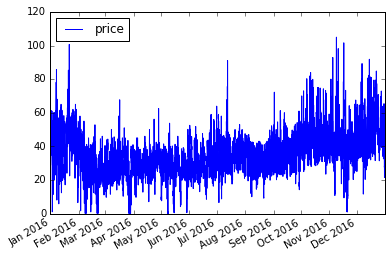

In [21]:
# plot timeseries
series.plot()

## Autocorrelation

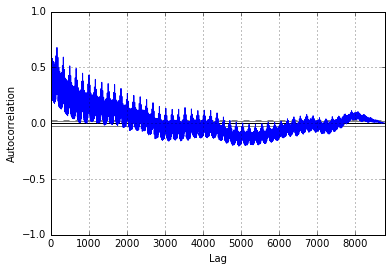

In [22]:
# plot autocorrelation
autocorrelation_plot(series)

## Fit ARIMA model

In [23]:
# fit ARIMA model and display summary for p=5, d=1 and q=0
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                 8783
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -27532.093
Method:                       css-mle   S.D. of innovations              5.561
Date:                Mon, 29 May 2017   AIC                          55078.187
Time:                        12:20:19   BIC                          55127.751
Sample:                    01-01-2016   HQIC                         55095.073
                         - 12-31-2016                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -9.635e-06      0.053     -0.000      1.000      -0.103       0.103
ar.L1.D.price     0.0450      0.011      4.234      0.000       0.024       0.066
ar.L2.D.price     0.0498      0.011     

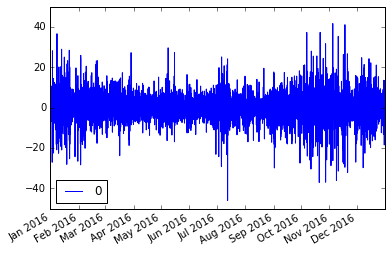

In [24]:
# plot residuals
residuals = pandas.DataFrame(model_fit.resid)
residuals.plot()

## Predict with ARIMA model

### Helper Functions

In [25]:
def plot_arima(fc, se, ci, true_prices):
    # fig size
    fig, ax = pyplot.subplots(figsize=(8,6))
    pyplot.xticks(fontsize = 18)
    pyplot.yticks(fontsize = 18)
    pyplot.xlabel('Hour', fontsize = 18)
    pyplot.ylabel('Price [Euro]', fontsize = 18)

    # plot data
    x = range(0,len(fc))
    ax.plot(x, fc, color = 'blue')
    ax.plot(x, true_prices, color = 'black')

    # plot confidence interval
    ci_bottom = ci[:,0]
    ci_top = ci[:,1]
    ax.fill_between(x, ci_top, ci_bottom, color='#b9cfe7', edgecolor='')

In [26]:
def train_and_predict_arima(series, p, d, q, n = 48):
    """Print mse, plot and return figure."""

    # fit ARIMA model
    model = ARIMA(series, order=(p,d,q))
    model_fit = model.fit(disp=0)

    # forecast
    fc_group = model_fit.forecast(n)

    # extract array of forecasts, array of standard error and array of 95% confidence interval
    fc = fc_group[0]
    se = fc_group[1]
    ci = fc_group[2]

    # compare forecast and true values
    true_prices = true_values[:n, 1]

    fig = plot_arima(fc, se, ci, true_prices)
    
    mse = sum(map((lambda x: x **2), np.array(fc) - np.array(true_prices))) / len(fc)
    print("mse:", mse)
    return fig

### Various ARIMA models

mse: 523.728505325


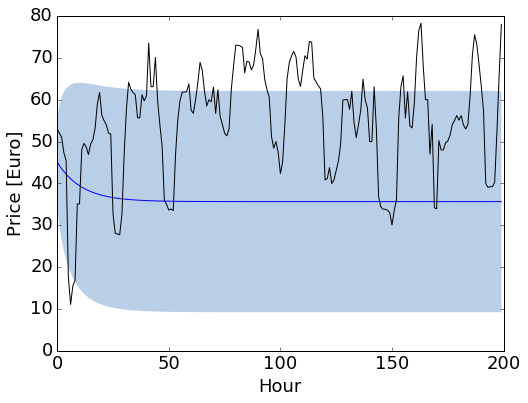

In [86]:
fig = train_and_predict_arima(series, 1, 0, 0, n = 200)

mse: 525.221521683


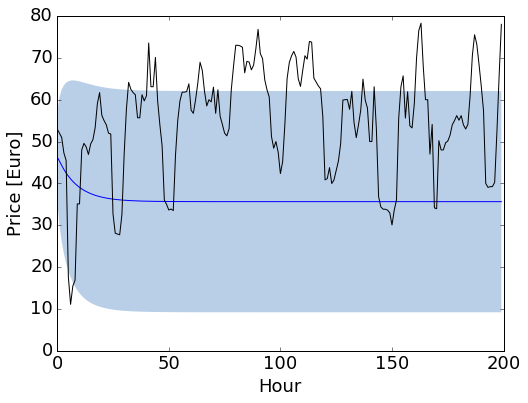

In [87]:
train_and_predict_arima(series, 2, 0, 0, n = 200)

mse: 525.975262364


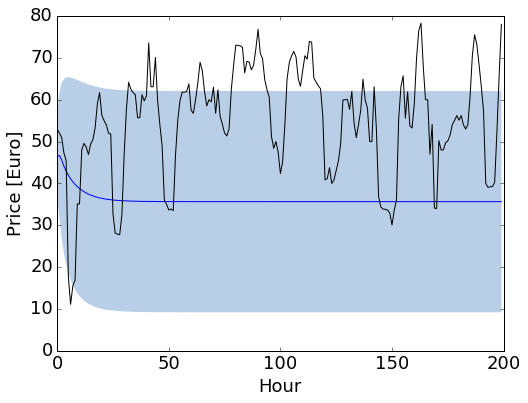

In [91]:
train_and_predict_arima(series, 5, 0, 0, n = 200)

mse: 223.052387515


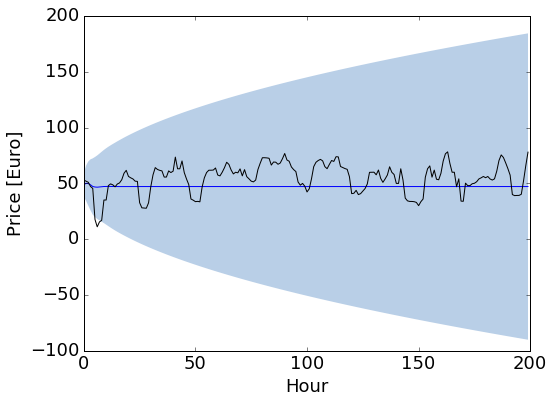

In [92]:
train_and_predict_arima(series, 5, 1, 0, n = 200)

mse: 39792.2208068


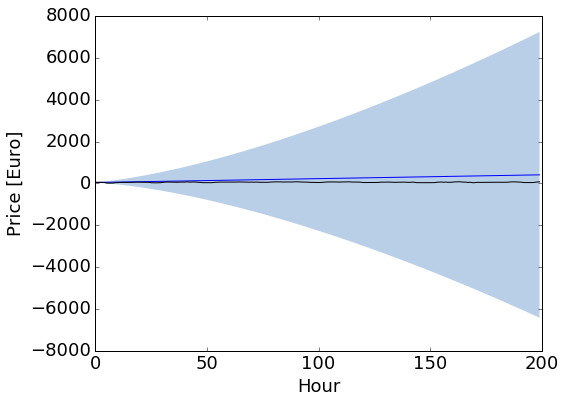

In [93]:
train_and_predict_arima(series, 5, 2, 0, n = 200)

mse: 212.674719495


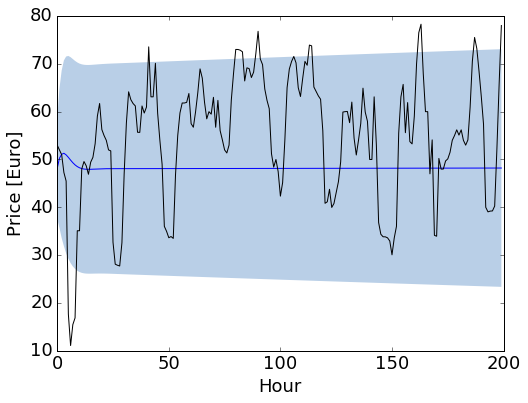

In [94]:
train_and_predict_arima(series, 5, 1, 1, n = 200)

mse: 178.030019149


/Users/ales/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


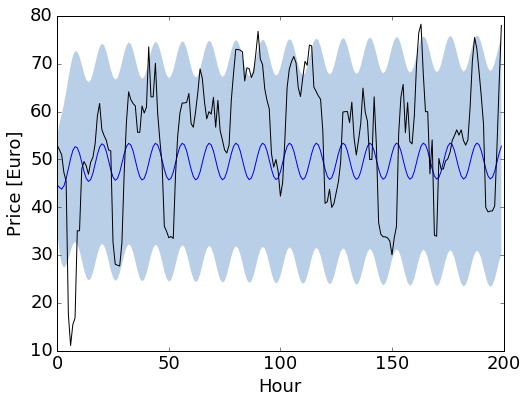

In [95]:
train_and_predict_arima(series, 5, 1, 3, n = 200)

mse: 256.714295658


/Users/ales/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


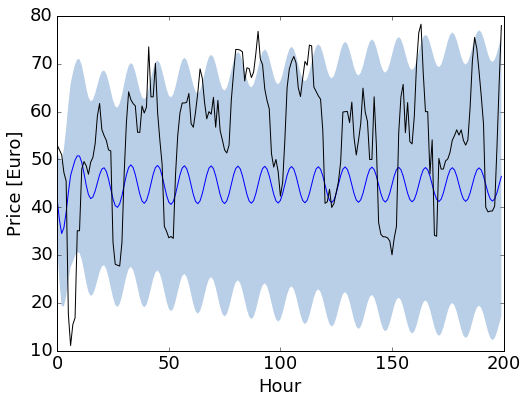

In [96]:
train_and_predict_arima(series, 10, 1, 3, n = 200)

mse: 195.530040185


/Users/ales/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/ales/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


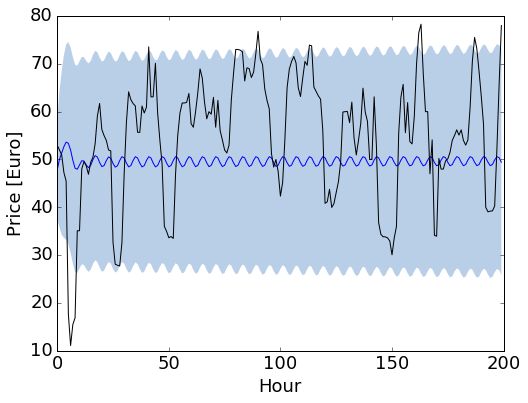

In [97]:
train_and_predict_arima(series, 10, 1, 5, n = 200)

# Neural Networks

### Helper Functions

In [15]:
def plot_raw_and_predicted(raw_data, predicted_data, from_ = None, to_ = None):
    
    # check data length matching
    n = len(raw_data)
    m = len(predicted_data)
    if m != n:
        print("Error: raw_data length is " + n + " while predicted_data is " + m)
        
    # check input range parameters and set to deault if nothing passed
    if from_ == None:
        from_ = 0
    if to_ == None:
        to_ = n
    else:
        to_ = min(to_, n)

    # plot data
    font_size = 30
    fig, ax = pyplot.subplots(figsize=(40,6))
    pyplot.xticks(fontsize = font_size)
    pyplot.yticks(fontsize = font_size)
    pyplot.xlabel('Hour', fontsize = font_size)
    pyplot.ylabel('Price [Euro]', fontsize = font_size)
    range_ = range(from_,to_)
    ax.plot(range_, predicted_data[range_], color = 'blue')
    ax.plot(range_, raw_data[range_], color = 'black')

In [16]:
def split_datetime(datetimes):
    """Takes datetimes as an input and returns matrix with columns
    [hour, day, weekday, month]"""
    nn_datetime_np = np.array([])
    for nn_datetime in datetimes:
        nn_datetime = borzen_datetime_to_datetime(nn_datetime)
        tmp_arr = [nn_datetime.hour, nn_datetime.day, nn_datetime.weekday(), nn_datetime.month]
        try:
            nn_datetime_np = np.vstack((nn_datetime_np, tmp_arr))
        except:
            nn_datetime_np = np.array(tmp_arr)
    return nn_datetime_np

In [17]:
def combine_pucnik_and_prices(weather_pucnik_data, X):
# (patch) multiply data rows by 24 (the number of hours in one day)
    tmp_list = []
    for sample in weather_pucnik_data:
        tmp_list += [sample]*24
    weather_pucnik_mul = np.array(tmp_list)

    # combine datetime, price ... with weather data
    weather_pucnik_mul_price = np.hstack((weather_pucnik_mul, X))
    
    return weather_pucnik_mul_price

def loss(true, pred):
    loss = sklearn.metrics.mean_squared_error(true, pred)
    return loss

### Load Prices and Timestamps

In [18]:
# load prices 2016
prices_nn = load_borzen_tables(False)
prices_nn = Prices(prices_nn[:, 1], prices_nn[:, 0])
prices_2016 = prices_nn.prices.astype(float)

# load timestamp 2016, parse it and standardize it
timestamp_2016 = split_datetime(prices_nn.timestamps)
timestamp_2016_scaler = StandardScaler()
timestamp_2016_scaler.fit(timestamp_2016)
timestamp_2016_std = timestamp_2016_scaler.transform(timestamp_2016)

# load timestamp january 2017, parse it and standardize it
prices_jan = test_load_borzen_price_january(False)
timestamp_2017_jan = split_datetime(prices_jan.timestamps)
raw_prices_2017_jan = prices_jan.prices

Load 01 2016-Table 1.csv
Loading prices successful!
Load 02 2016-Table 1.csv
Loading prices successful!
Load 03 2016-Table 1.csv
Loading prices successful!
Load 04 2016-Table 1.csv
Loading prices successful!
Load 05 2016-Table 1.csv
Loading prices successful!
Load 06 2016-Table 1.csv
Loading prices successful!
Load 07 2016-Table 1.csv
Loading prices successful!
Load 08 2016-Table 1.csv
Loading prices successful!
Load 09 2016-Table 1.csv
Loading prices successful!
Load 10 2016-Table 1.csv
Loading prices successful!
Load 11 2016-Table 1.csv
Loading prices successful!
Load 12 2016-Table 1.csv
Loading prices successful!
Load test borzen prices.
Loading test borzen prices successful!


/Users/ales/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


### Load Weather Data

In [19]:
# load weather data
weather_pucnik_2016 = test_load_pucnik()
weather_pucnik_2017_jan = test_load_pucnik('/Users/ales/Desktop/STUDIJ/DodatnoLeto/'\
            'MatematikaZracunalnikom/WeatherDataTest/JozePucnikDailyDataJanuary')

# combine timestamp and weather
timestamp_weather_pucnik_2016 = combine_pucnik_and_prices(weather_pucnik_2016.data, timestamp_2016)
timestamp_weather_pucnik_2017_jan = combine_pucnik_and_prices(weather_pucnik_2017_jan.data, timestamp_2017_jan)

# standardize
pucnik_scaler = StandardScaler()
pucnik_scaler.fit(timestamp_weather_pucnik_2016)
timestamp_weather_pucnik_2016_std = pucnik_scaler.transform(timestamp_weather_pucnik_2016)
timestamp_weather_pucnik_2017_jan_std = pucnik_scaler.transform(timestamp_weather_pucnik_2017_jan)

Start loading joze pucnik
Loading successful
Start loading joze pucnik
Loading successful


## Fit 2016

In [33]:
X_train = timestamp_2016
y_train = prices_2016
P = X_train

# fit
neural = MLPRegressor(hidden_layer_sizes=(30, 30, 30, 30))
neural.fit(X_train, y_train)
# predict and print loss
pred = neural.predict(P)
print("Loss: " + str(loss(y_train, pred)))

Loss: 67.6756831036


## Fit 2016 Standardized

In [104]:
X_train = timestamp_2016_std
y_train = prices_2016
P = X_train

# fit
neural_std = MLPRegressor(hidden_layer_sizes=(30, 30, 30, 30))
neural_std.fit(X_train, y_train)
# predict and print loss
pred = neural_std.predict(P)
print("Loss: " + str(loss(y_train, pred)))

Loss: 59.0883670896


## Predict January

Not standardized

Loss: 1514.68939426


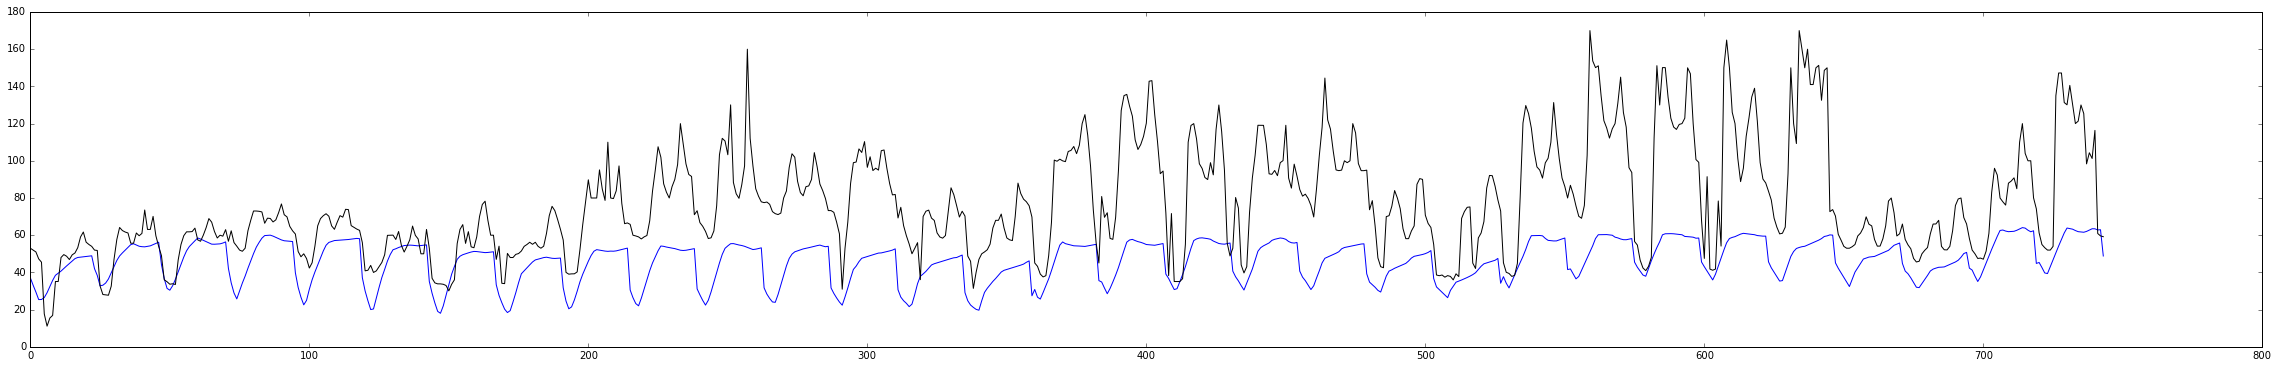

In [431]:
P = timestamp_2017_jan
true = raw_prices_2017_jan

# predict, plot, print loss
predicted = neural.predict(P)
plot_raw_and_predicted(true, predicted)
print("Loss: " + str(loss(true, predicted)))


Standardized

Loss: 1688.14873866


/Users/ales/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


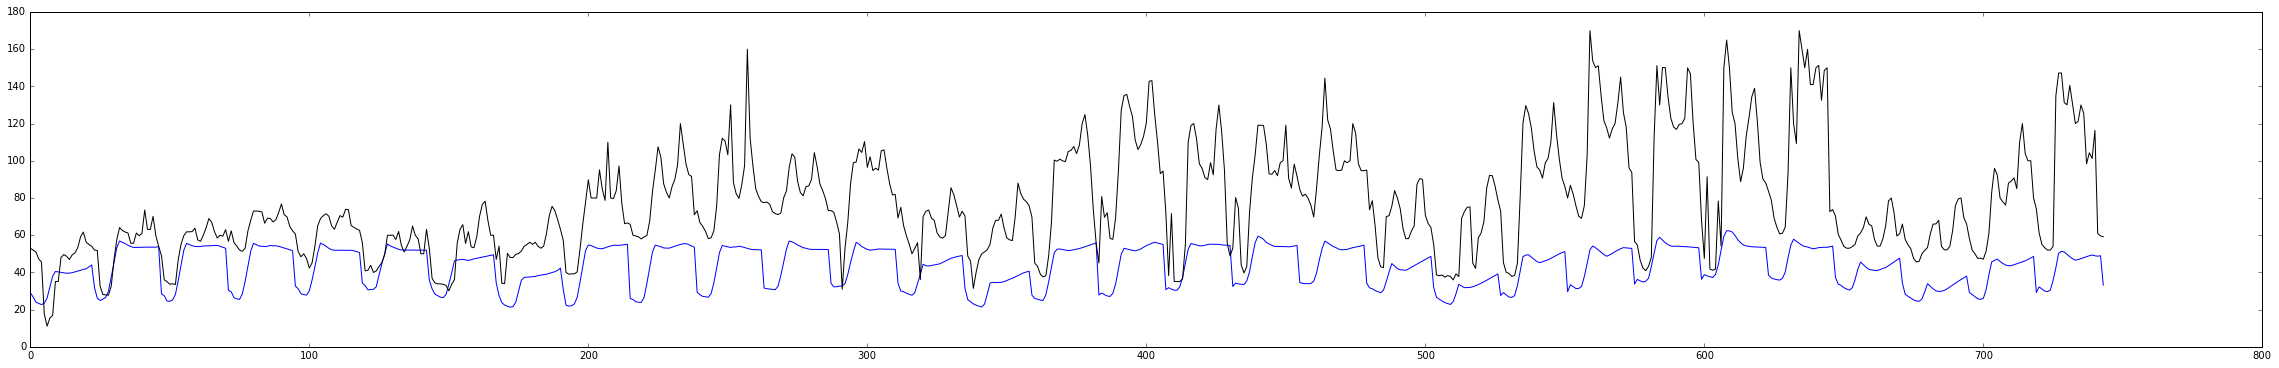

In [432]:
# standardize
timestamp_2017_jan_std = timestamp_2016_scaler.transform(timestamp_2017_jan)
P = timestamp_2017_jan_std
true = raw_prices_2017_jan

# predict, plot, print loss
predicted = neural_std.predict(P)
plot_raw_and_predicted(true, predicted)
print("Loss: " + str(loss(true, predicted)))

# Predict 2016

Loss: 66.9474381903


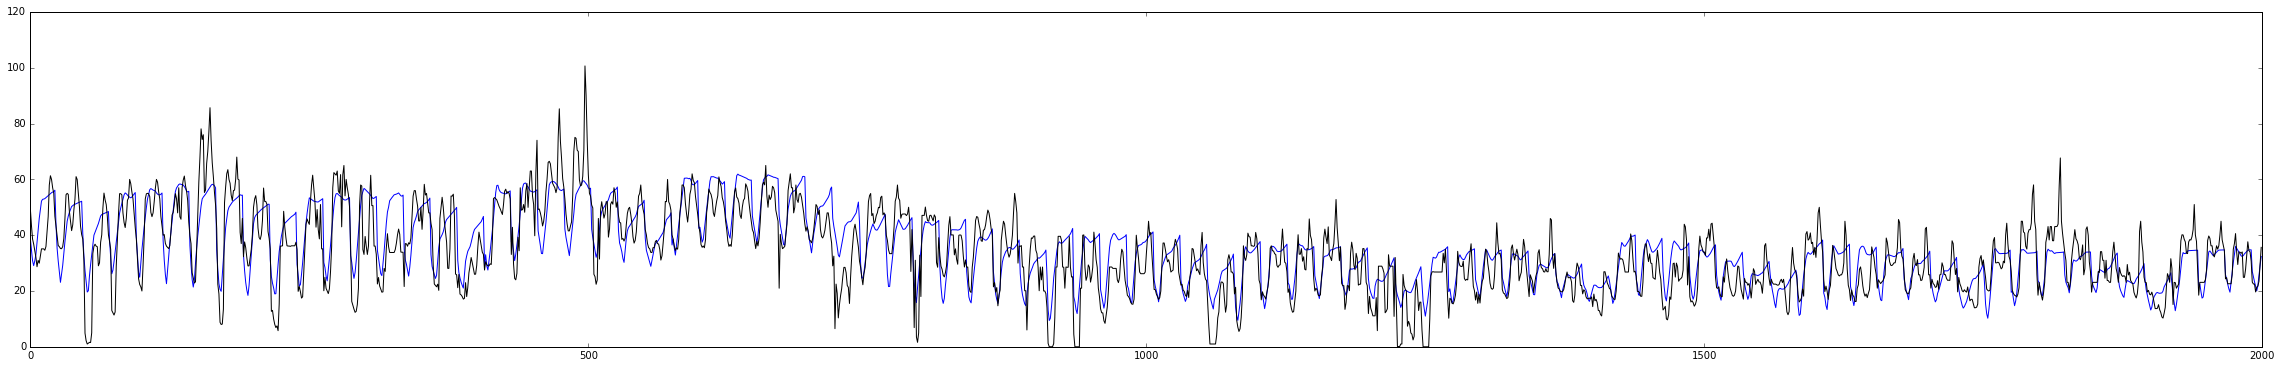

In [434]:
# Prediction on non-standardized data
predicted = neural.predict(timestamp_2016)
plot_raw_and_predicted(prices_2016, predicted, 0, 2000)
print("Loss: " + str(loss(prices_2016, predicted)))

Loss: 59.5006320196


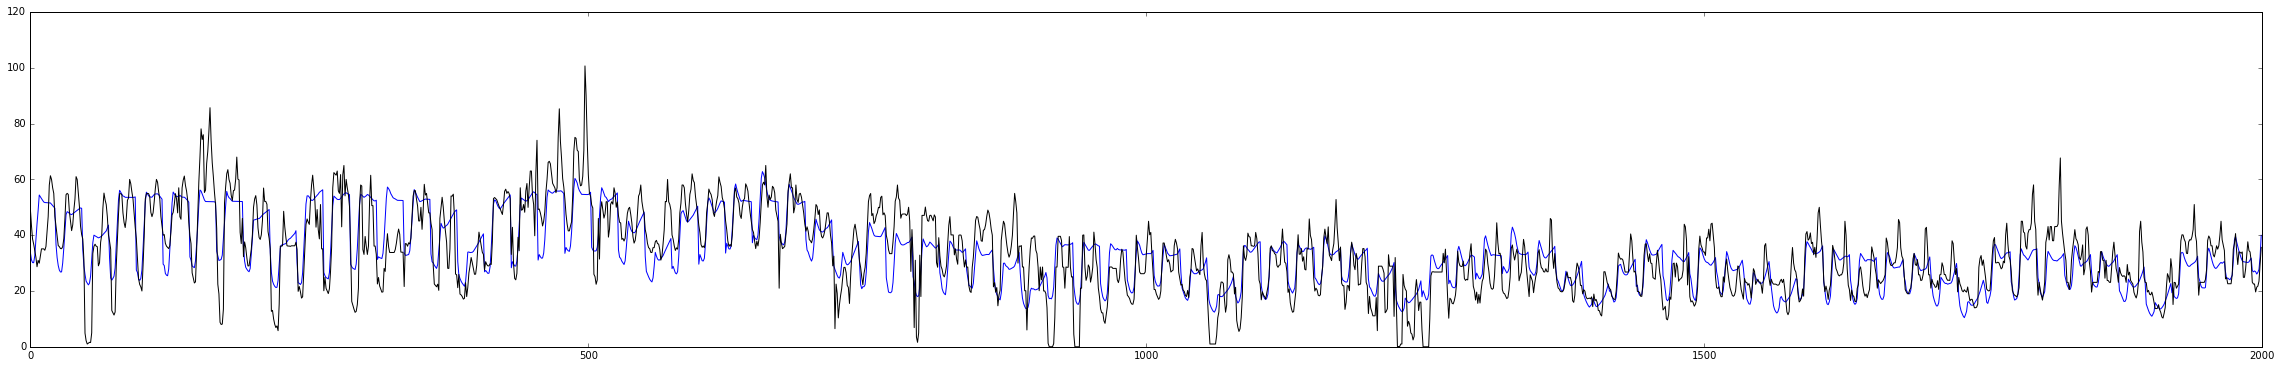

In [435]:
# Prediction on STANDARDIZED data
predicted = neural_std.predict(timestamp_2016_std)
plot_raw_and_predicted(prices_2016, predicted, 0, 2000)
print("Loss: " + str(loss(prices_2016, predicted)))

## Append average daily weather data

Append  
'povp. dnevna T [°C]',  
'količina padavin [mm]',  
'višina novega snega [cm]',  
'oblačnost [%]'

In [ ]:
X_train = timestamp_weather_pucnik_2016_std
y_train = prices_2016
P = timestamp_weather_pucnik_2016_std

Loss: 36.6097958064


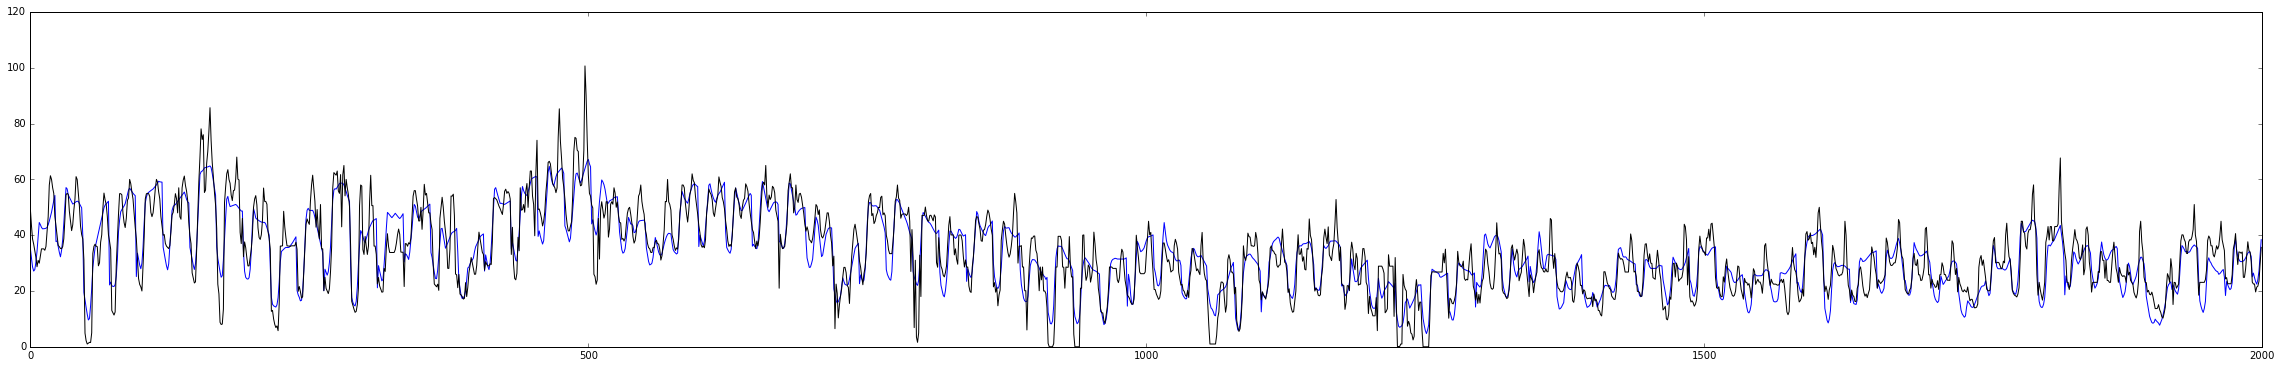

In [437]:
# fit the model
neural_pucnik_30303030 = MLPRegressor(hidden_layer_sizes=(30, 30, 30, 30))
neural_pucnik_30303030.fit(X_train, y_train)

# predict, plot, print loss
predicted = neural_pucnik_30303030.predict(P)
plot_raw_and_predicted(prices_2016, predicted, 0, 2000)
print("Loss: " + str(loss(prices_2016, predicted)))

Loss: 33.6457263877


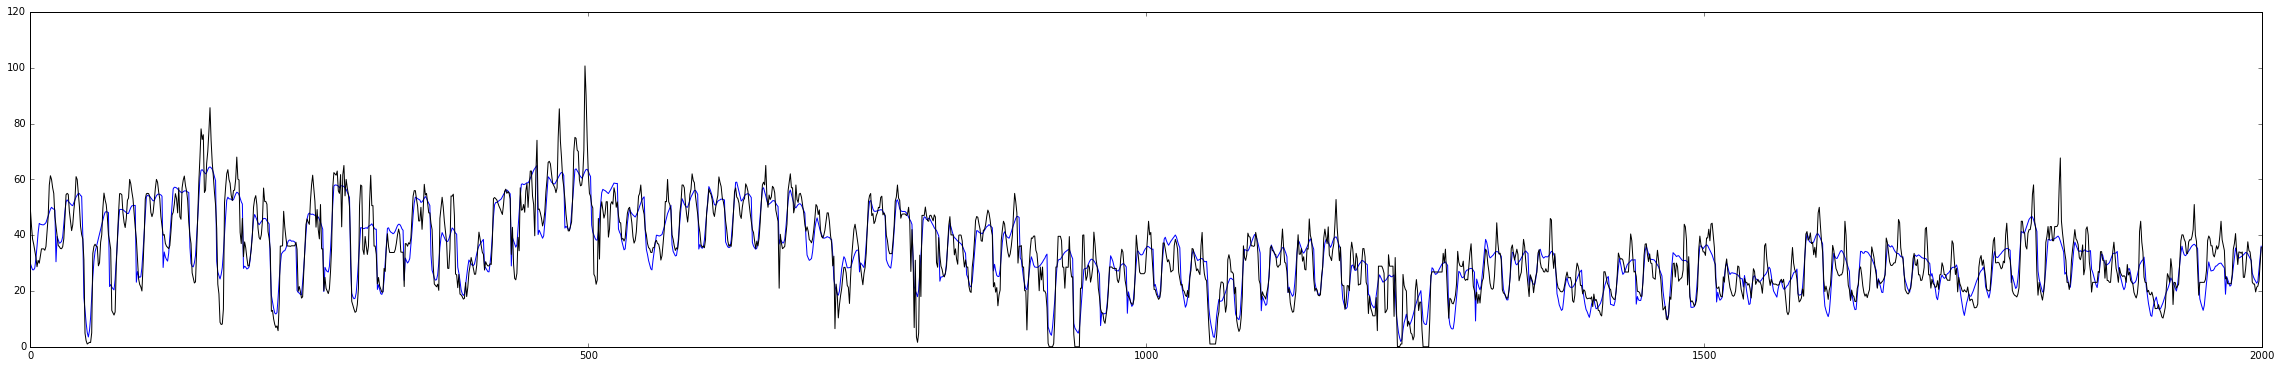

In [438]:
# fit the model
neural_pucnik_100100 = MLPRegressor(hidden_layer_sizes=(100, 100))
neural_pucnik_100100.fit(X_train, y_train)

# predict, plot, print loss
predicted = neural_pucnik_100100.predict(P)
plot_raw_and_predicted(prices_2016, predicted, 0, 2000)
print("Loss: " + str(loss(prices_2016, predicted)))

Loss: 29.0248846697


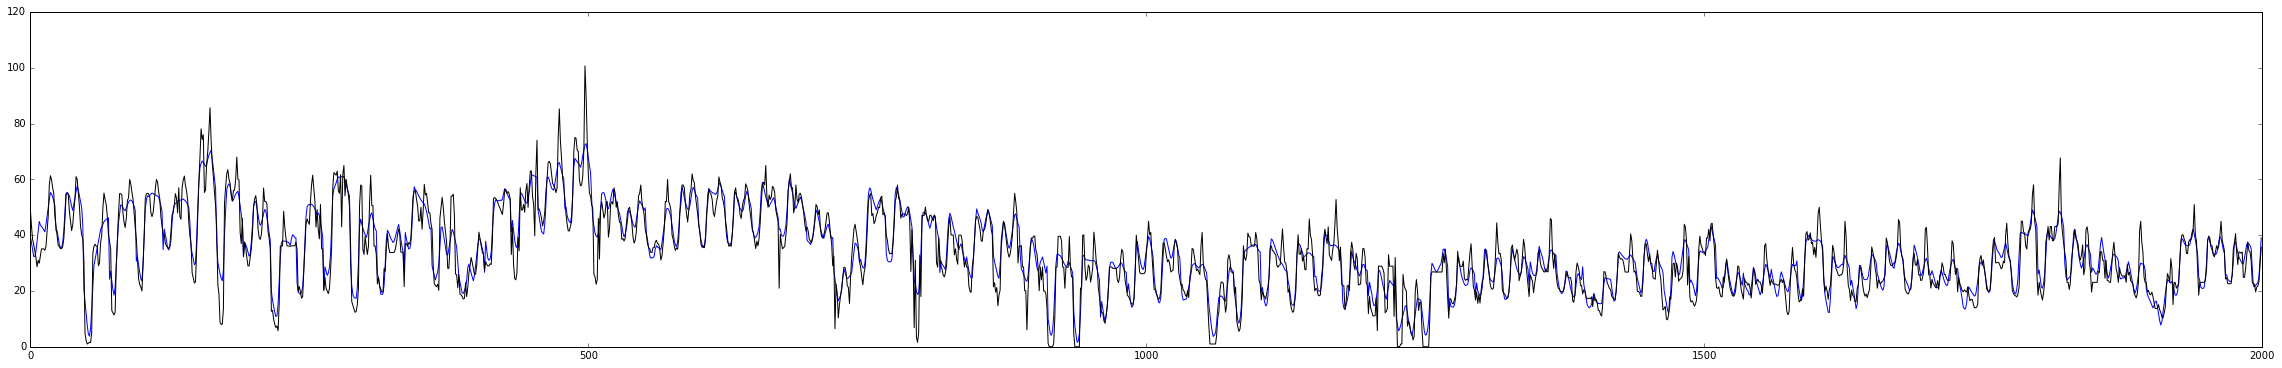

In [439]:
# fit the model
neural_pucnik_100100100 = MLPRegressor(hidden_layer_sizes=(100, 100, 100))
neural_pucnik_100100100.fit(X_train, y_train)

# predict, plot, print loss
predicted = neural_pucnik_100100100.predict(P)
plot_raw_and_predicted(prices_2016, predicted, 0, 2000)
print("Loss: " + str(loss(prices_2016, predicted)))

Loss: 27.6882849269


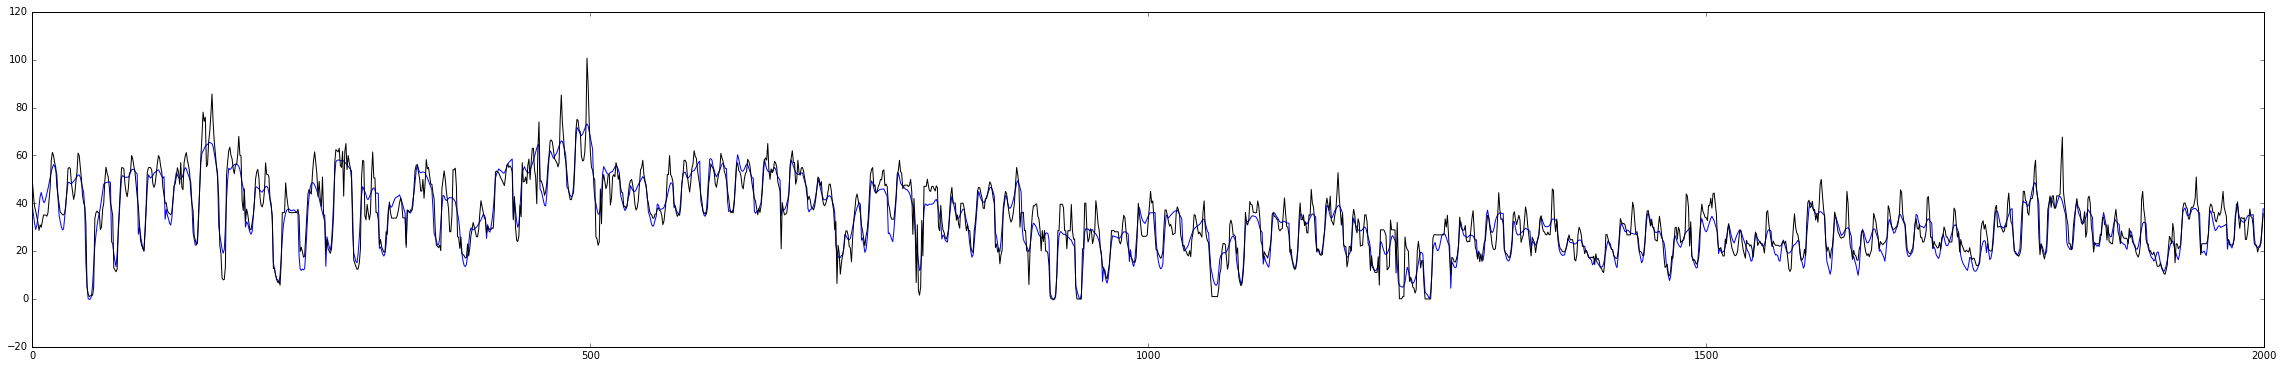

In [440]:
# fit the model
neural_pucnik_100100100100 = MLPRegressor(hidden_layer_sizes=(100, 100, 100, 100))
neural_pucnik_100100100100.fit(X_train, y_train)

# predict, plot, print loss
predicted = neural_pucnik_fit_100100100100.predict(P)
plot_raw_and_predicted(prices_2016, predicted, 0, 2000)
print("Loss: " + str(loss(prices_2016, predicted)))

### Predict with NN on January data

In [ ]:
tw = timestamp_weather_pucnik_2017_jan_std
rp = raw_prices_2017_jan

Loss: 1699.69617551


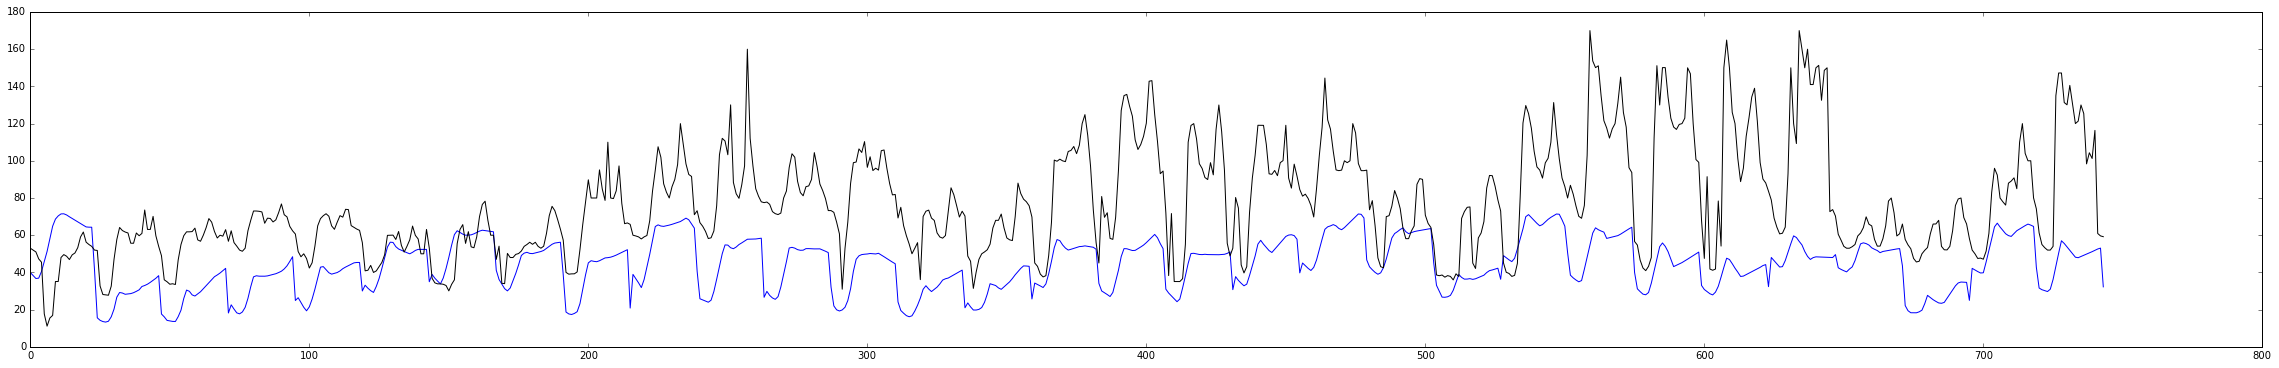

In [453]:
plot_true_and_pred(neural_pucnik_30303030, tw, rp)

Loss: 1668.31796535


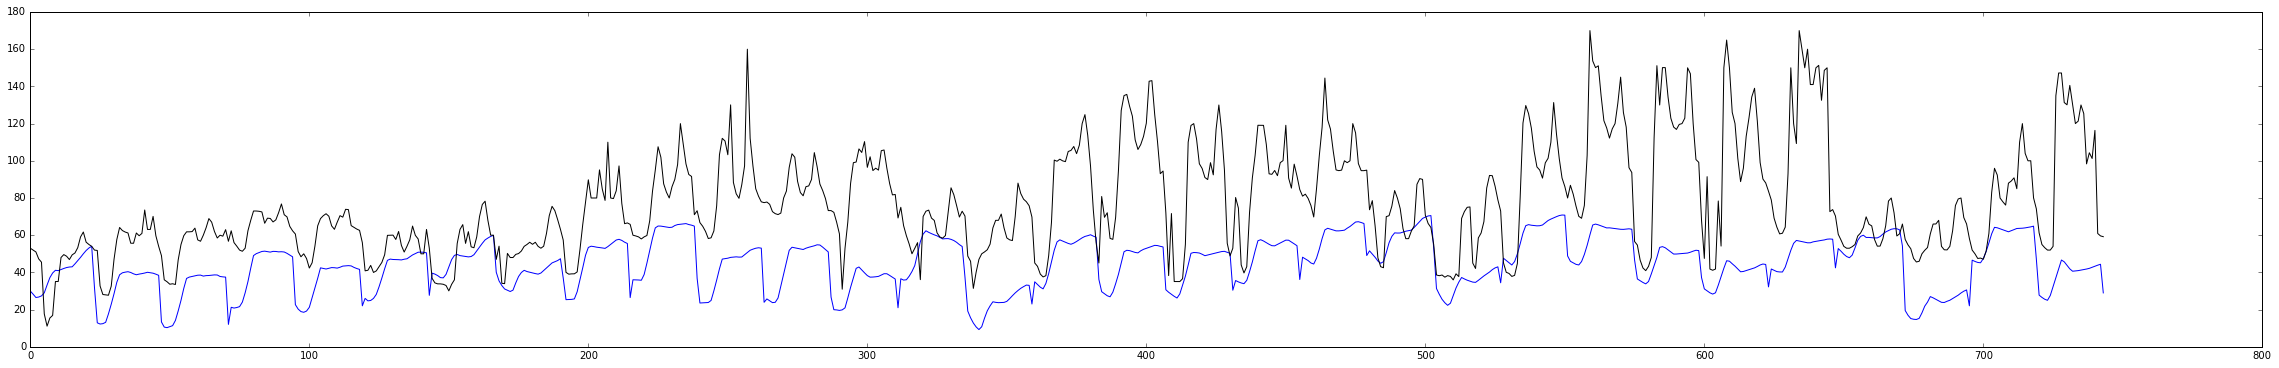

In [454]:
plot_true_and_pred(neural_pucnik_100100, tw, rp)

Loss: 1886.04297658


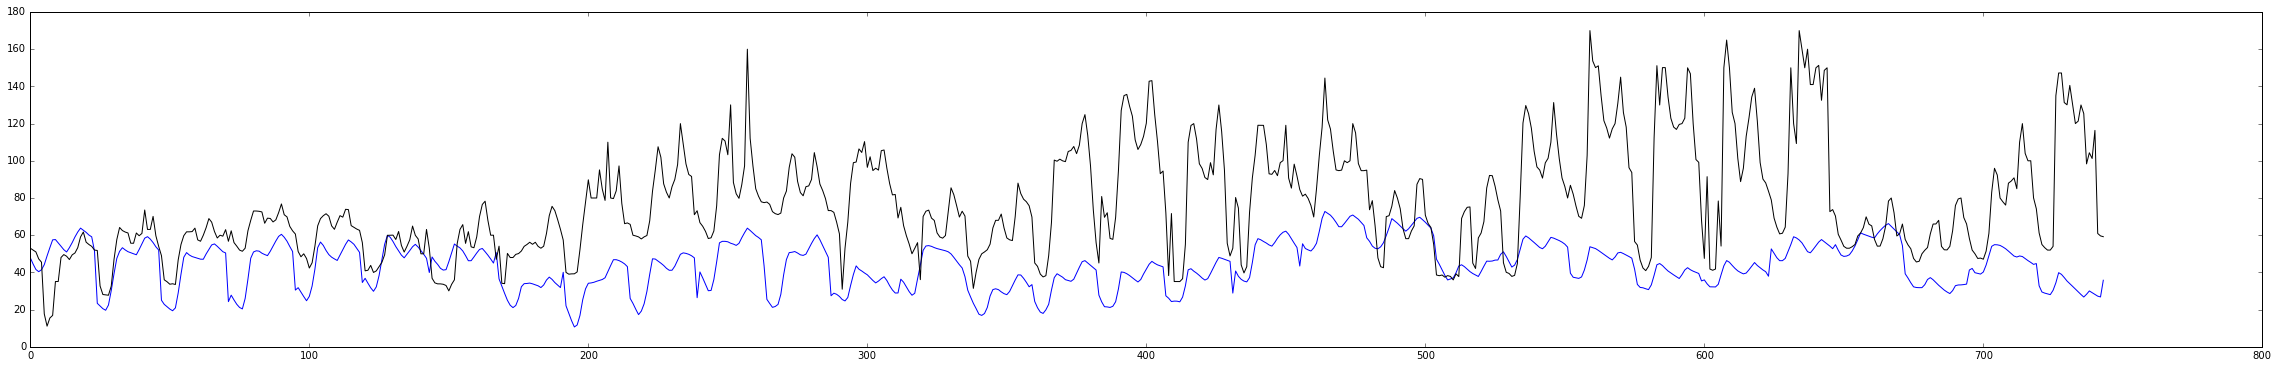

In [456]:
plot_true_and_pred(neural_pucnik_100100100, tw, rp)

Loss: 1867.7695661


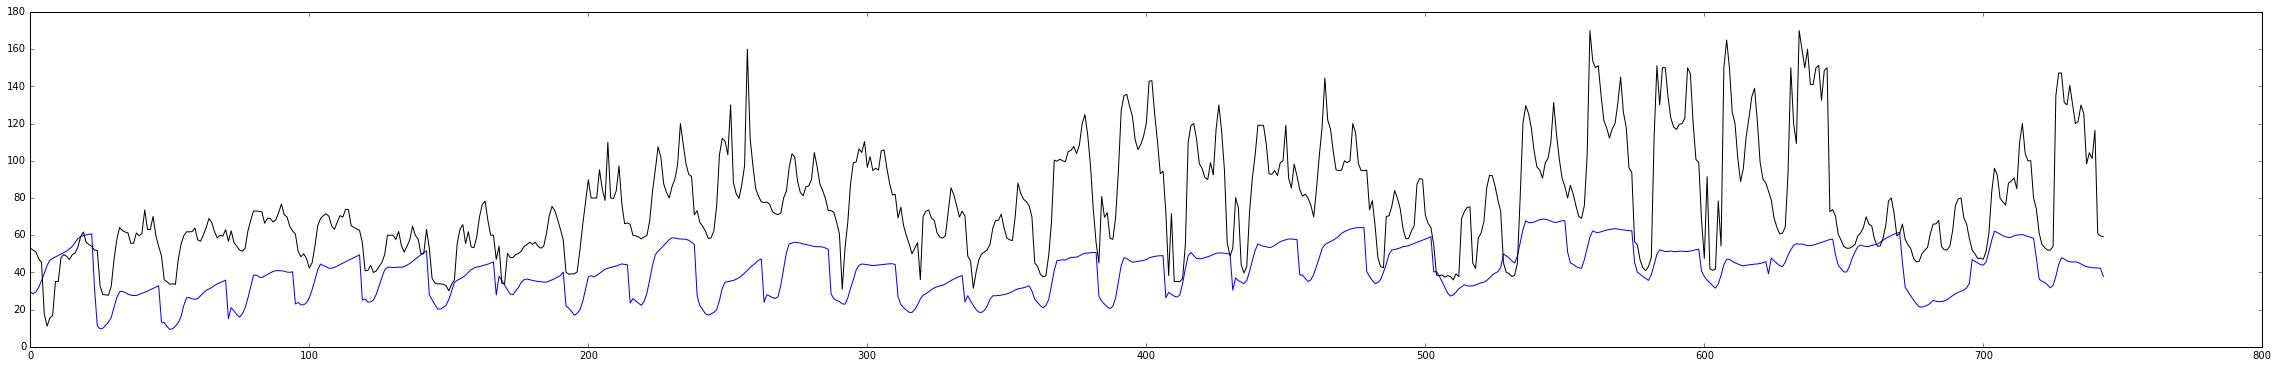

In [455]:
plot_true_and_pred(neural_pucnik_100100100100, tw, rp)

## Include shuffling

In [20]:
from sklearn.utils import shuffle

In [21]:
# shuffle training data
timestamp_weather_pucnik_2016_std_sh, prices_2016_sh = shuffle(timestamp_weather_pucnik_2016_std, prices_2016)

In [22]:
X_train = timestamp_weather_pucnik_2016_std_sh
y_train = prices_2016_sh

# fit the model
neural_pucnik = MLPRegressor(hidden_layer_sizes=(100, 100, 100, 100))
neural_pucnik.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100, 100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

Loss: 19.7381844002


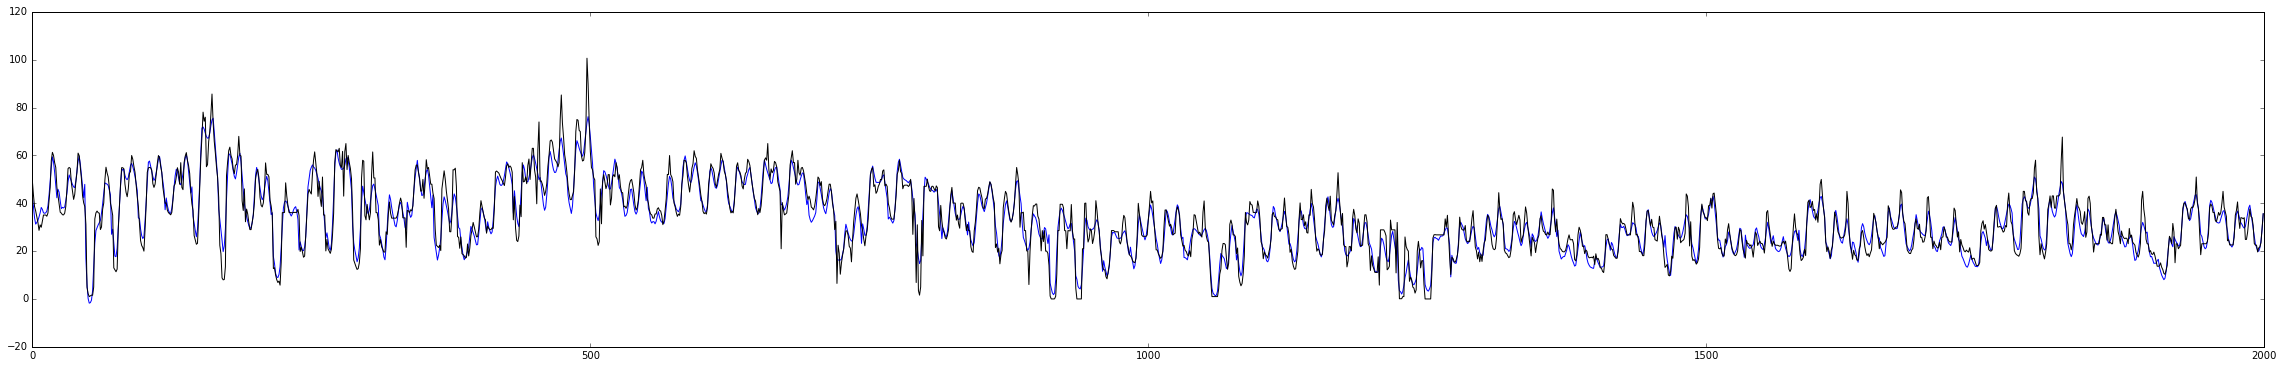

In [470]:
# plot 2016
P = timestamp_weather_pucnik_2016_std
true = prices_2016
plot_true_and_pred(neural_pucnik, P, true, plot=True)

Loss: 2138.91957413


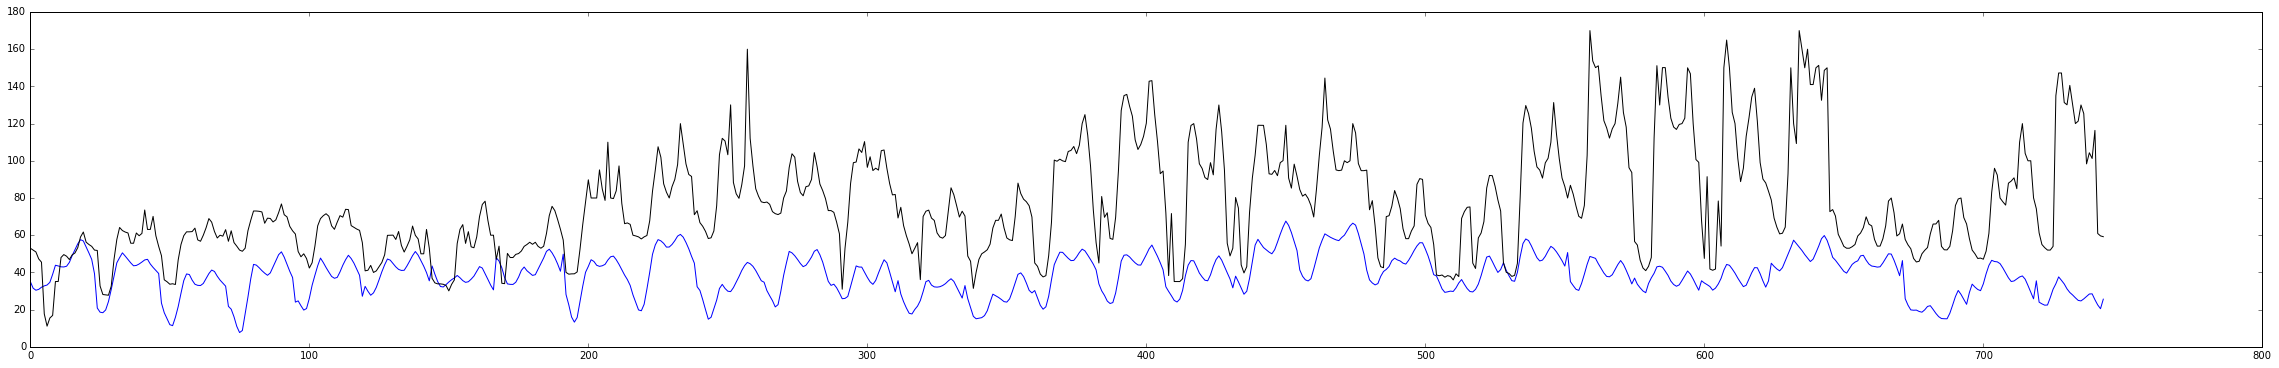

In [471]:
# print January
P = timestamp_weather_pucnik_2017_jan_std
true = raw_prices_2017_jan
plot_true_and_pred(neural_pucnik, P, true, plot=True)

#### Compare by Cross-Validation

In [115]:
# model
neural_pucnik_30303030 = MLPRegressor(hidden_layer_sizes=(30, 30, 30, 30))
neural_pucnik_100100 = MLPRegressor(hidden_layer_sizes=(100, 100))
neural_pucnik_100100100 = MLPRegressor(hidden_layer_sizes=(100, 100, 100))
neural_pucnik_100100100100 = MLPRegressor(hidden_layer_sizes=(100, 100, 100, 100))

#### Non-shuffled

In [ ]:
X_train = timestamp_weather_pucnik_2016_std
y_train = prices_2016

In [475]:
# non-random 30 30 30 30
scores = cross_val_score(neural_pucnik_30303030, X_train, y_train, 
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 147.46 (+/- 219.28)


In [116]:
# non-random 100 100
scores = cross_val_score(neural_pucnik_100100, X_train, y_train,  
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 147.55 (+/- 242.19)


/Users/ales/anaconda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


In [117]:
# non-random 100 100 100
scores = cross_val_score(neural_pucnik_100100100, X_train, y_train, 
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 147.07 (+/- 254.78)


In [473]:
# non-random 100 100 100 100
scores = cross_val_score(neural_pucnik_100100100100, X_train, y_train, 
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 161.96 (+/- 329.38)


#### Shuffled

In [ ]:
X_train = timestamp_weather_pucnik_2016_std_sh
y_train = prices_2016_sh

In [476]:
# shuffled 30 30 30 30
scores = cross_val_score(neural_pucnik_30303030, X_train, y_train,
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 49.41 (+/- 10.02)


In [123]:
# shuffled 100 100
scores = cross_val_score(neural_pucnik_100100, X_train, y_train,
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 42.18 (+/- 7.78)


In [122]:
# shuffled 100 100 100
scores = cross_val_score(neural_pucnik_100100100, X_train, y_train,
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 37.31 (+/- 11.00)


In [474]:
# shuffled 100 100 100 100
scores = cross_val_score(neural_pucnik_100100100100, X_train, y_train,
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 37.48 (+/- 14.34)


## Append Consumption

In [48]:
consumption_2016 = load_power_consumption_2016(False)

# Warning: Decenber 2016 is missing for consumption
tmp = Prices(consumption_2016[:, 1], consumption_2016[:, 0])

consumption_2016 = tmp.prices.astype(float)

Load 01 2016-Table 1.csv
Loading prices successful!
Load 02 2016-Table 1.csv
Loading prices successful!
Load 03 2016-Table 1.csv
Loading prices successful!
Load 04 2016-Table 1.csv
Loading prices successful!
Load 05 2016-Table 1.csv
Loading prices successful!
Load 06 2016-Table 1.csv
Loading prices successful!
Load 07 2016-Table 1.csv
Loading prices successful!
Load 08 2016-Table 1.csv
Loading prices successful!
Load 09 2016-Table 1.csv
Loading prices successful!
Load 10 2016-Table 1.csv
Loading prices successful!
Load 11 2016-Table 1.csv
Loading prices successful!
Load 01 2017-Table 1.csv
Loading prices successful!


In [24]:
# Combine demand with the 'previous' training data
# Missing December is considered by removing December from the 'old' training data
n = len(consumption_2016)
timestamp_weather_pucnik_demand_2016_ = np.column_stack((timestamp_weather_pucnik_2016[0:n], consumption_2016))
prices_2016_ = prices_2016[0:n] # December missing

In [25]:
# standardize
std_demand = StandardScaler()
std_demand.fit(timestamp_weather_pucnik_demand_2016_)
timestamp_weather_pucnik_demand_2016_std_ = std_demand.transform(timestamp_weather_pucnik_demand_2016_)

# shuffle
timestamp_weather_pucnik_demand_2016_std_sh_, prices_2016_sh_ = sklearn.utils.shuffle(
    timestamp_weather_pucnik_demand_2016_std_, prices_2016_)

#### Cross-validate

In [ ]:
X_train = timestamp_weather_pucnik_demand_2016_std_sh_
y_train = prices_2016_sh_

In [129]:
# 30 30 30 30 
scores = cross_val_score(neural_pucnik_30303030, X_train, y_train, 
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 43.01 (+/- 10.28)


In [128]:
# 100 100
scores = cross_val_score(neural_pucnik_100100, X_train, y_train, 
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 35.68 (+/- 9.27)


In [127]:
# 100 100 100
scores = cross_val_score(neural_pucnik_100100100, X_train, y_train, 
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 31.58 (+/- 4.10)


In [575]:
# 100 100 100 100
scores = cross_val_score(neural_pucnik_100100100100, X_train, y_train, 
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 29.93 (+/- 7.32)


### Correlation between consumption and price

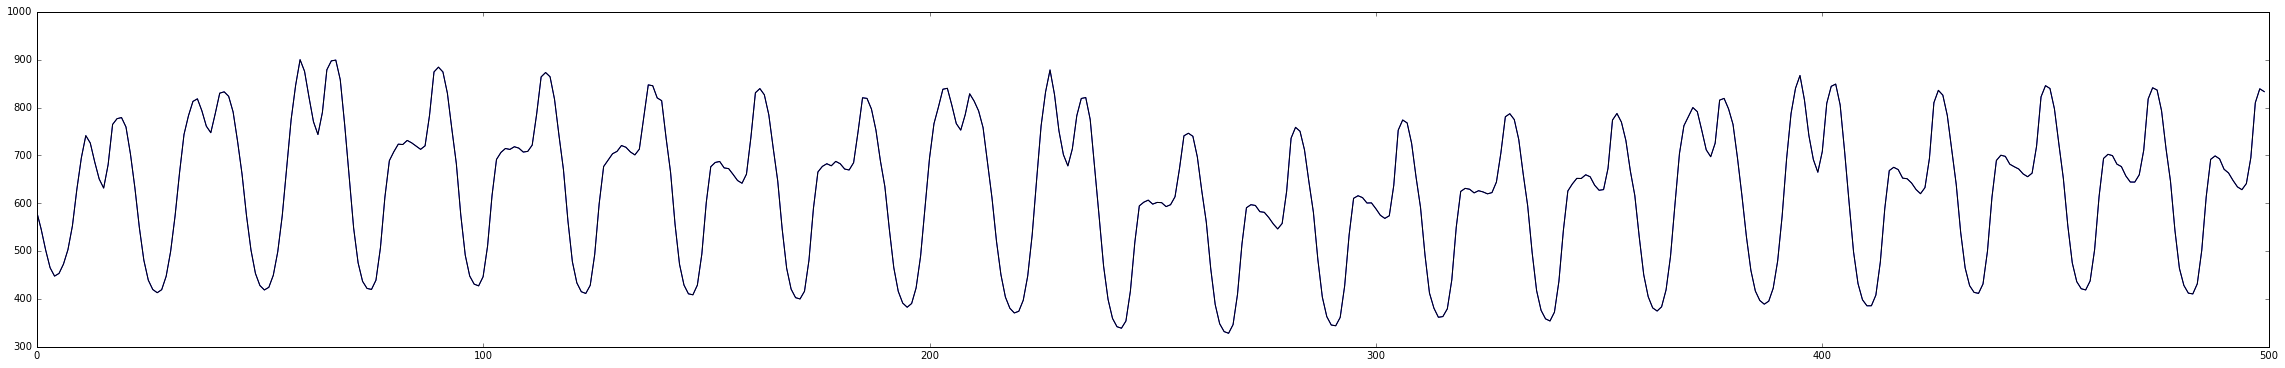

In [585]:
# Plot consumption
plot_raw_and_predicted(consumption_2016, consumption_2016, 0, 500)

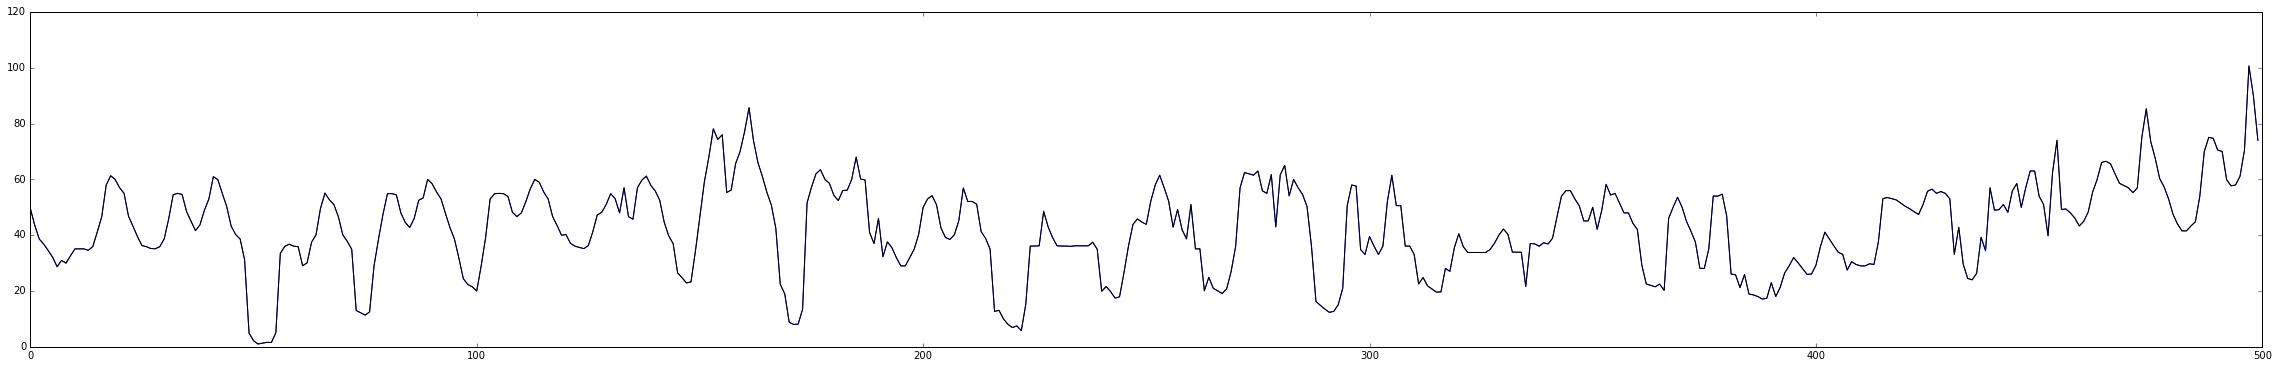

In [586]:
plot_raw_and_predicted(prices_2016_, prices_2016_, 0, 500)

We can see that demand is much more stable than price. Weekends are clearly noticable. Also 1st, 2nd and 3rd January (holidays). Therefore, it may be sensible to predict demand which is then used for price prediction.

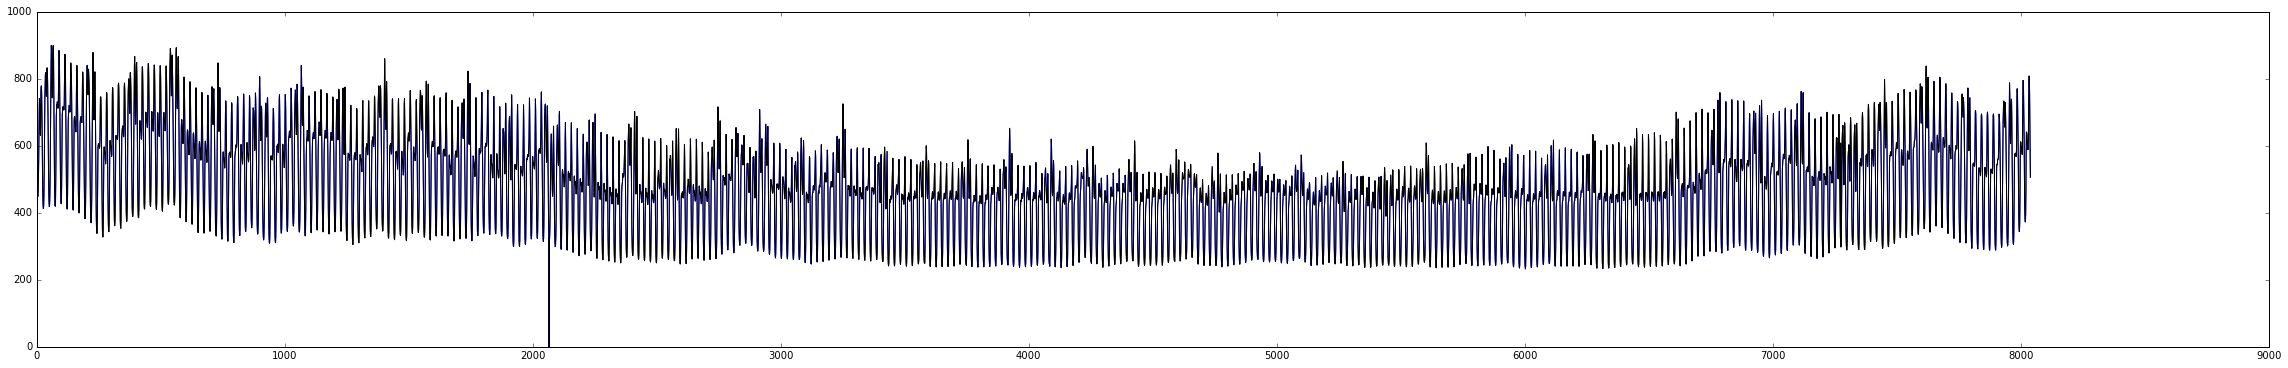

In [587]:
# Plot consumption
plot_raw_and_predicted(consumption_2016, consumption_2016)

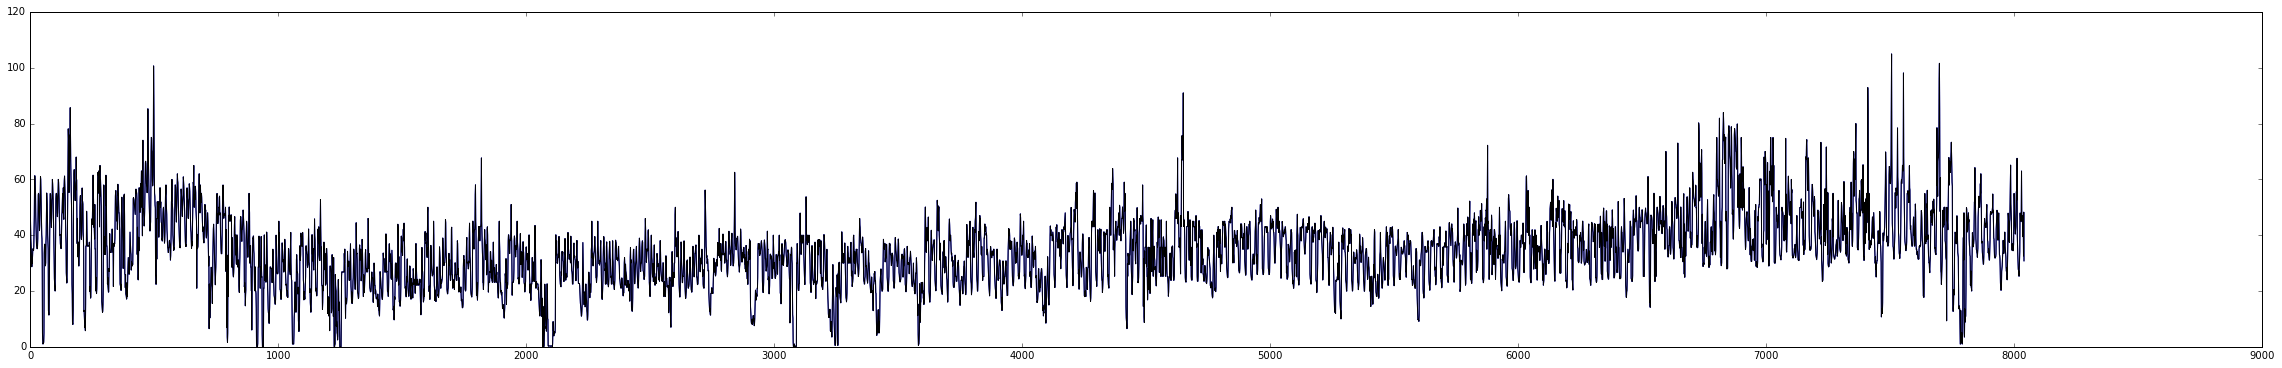

In [596]:
# Plot prices
plot_raw_and_predicted(prices_2016_, prices_2016_)

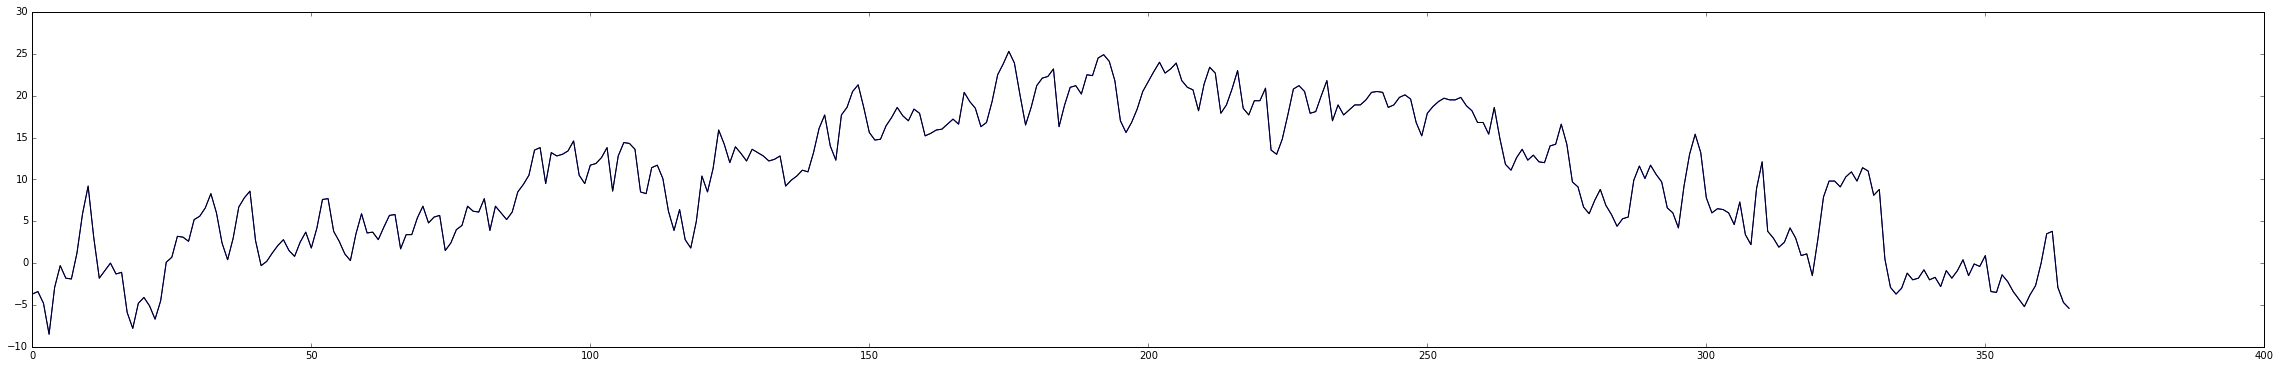

In [595]:
# Plot temperature
temp = weather_pucnik_2016.data[:,0]
plot_raw_and_predicted(temp, temp)

## Add PCA

Standardization has to be done first, then PCA!

[ 0.23762791  0.15950552  0.1331012   0.11703808  0.1076334   0.09339966
  0.07142484  0.05988092  0.02038848]


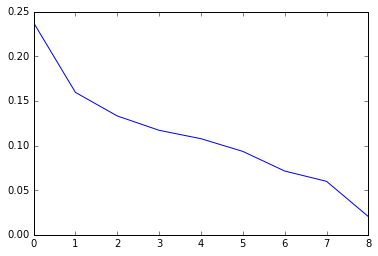

In [130]:
from sklearn import decomposition

# fit pca
pca = decomposition.PCA()
pca.fit(timestamp_weather_pucnik_demand_2016_std_sh_)

# plot variance
print(pca.explained_variance_ratio_) 
pyplot.plot(pca.explained_variance_ratio_) 

In [131]:
def score_based_on_components(n_comp):
    # take first n_comp dimensions
    pca = decomposition.PCA(n_components=n_comp)
    pca.fit(timestamp_weather_pucnik_demand_2016_std_sh_)
    timestamp_weather_pucnik_demand_2016_std_sh_pca_ = pca.transform(timestamp_weather_pucnik_demand_2016_std_sh_)

    # shuffled 100 100 100 100
    scores = cross_val_score(neural_pucnik_100100100100, timestamp_weather_pucnik_demand_2016_std_sh_pca_, prices_2016_sh_, 
                             cv=10, scoring='neg_mean_squared_error')
    print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

In [134]:
for i in range(1,9):
    score_based_on_components(i)

Accuracy: 155.27 (+/- 17.51)
Accuracy: 127.70 (+/- 20.92)
Accuracy: 94.16 (+/- 14.46)
Accuracy: 71.29 (+/- 10.31)
Accuracy: 53.10 (+/- 10.48)
Accuracy: 41.63 (+/- 7.87)
Accuracy: 39.30 (+/- 8.66)
Accuracy: 35.25 (+/- 8.47)


# Deep Learning

In [26]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [627]:
# define base model
DIM = len(timestamp_weather_pucnik_demand_2016_std_sh_[0])
def baseline_model():
    # create model
    model = Sequential()
    # add one more node to the first layer as an intercept
    model.add(Dense(DIM+1, input_dim=DIM, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# evaluate model
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=0)

# scores
scores = cross_val_score(estimator, timestamp_weather_pucnik_demand_2016_std_sh_, prices_2016_sh_, 
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

In [630]:
# define base model
DIM = len(timestamp_weather_pucnik_demand_2016_std_sh_[0])
def baseline_model():
    # create model
    model = Sequential()
    # add one more node to the first layer as an intercept
    model.add(Dense(DIM+1, input_dim=DIM, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# evaluate model
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=0)

# scores
scores = cross_val_score(estimator, timestamp_weather_pucnik_demand_2016_std_sh_, prices_2016_sh_, 
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 64.16 (+/- 24.39)


In [632]:
# define base model
DIM = len(timestamp_weather_pucnik_demand_2016_std_sh_[0])
def baseline_model():
    # create model
    model = Sequential()
    # add one more node to the first layer as an intercept
    model.add(Dense(30, input_dim=DIM, kernel_initializer='normal', activation='relu'))
    model.add(Dense(30, kernel_initializer='normal', activation='relu'))
    model.add(Dense(30, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# evaluate model
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=15, verbose=0)

# scores
scores = cross_val_score(estimator, timestamp_weather_pucnik_demand_2016_std_sh_, prices_2016_sh_, 
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 77.76 (+/- 10.25)


In [634]:
# define base model
DIM = len(timestamp_weather_pucnik_demand_2016_std_sh_[0])
def baseline_model():
    # create model
    model = Sequential()
    # add one more node to the first layer as an intercept
    model.add(Dense(100, input_dim=DIM, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# evaluate model
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=0)

# scores
scores = cross_val_score(estimator, timestamp_weather_pucnik_demand_2016_std_sh_, prices_2016_sh_, 
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 61.08 (+/- 10.53)


In [633]:
# define base model
DIM = len(timestamp_weather_pucnik_demand_2016_std_sh_[0])
def baseline_model():
    # create model
    model = Sequential()
    # add one more node to the first layer as an intercept
    model.add(Dense(100, input_dim=DIM, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# evaluate model
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=0)

# scores
scores = cross_val_score(estimator, timestamp_weather_pucnik_demand_2016_std_sh_, prices_2016_sh_, 
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 50.97 (+/- 10.42)


# Deep Learning 2

Explanation about batch_size, epoch and iterations:
    https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network
    
one epoch = one forward pass and one backward pass of all the training examples

batch size = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.

number of iterations = number of passes, each pass using [batch size] number of examples. To be clear, one pass = one forward pass + one backward pass (we do not count the forward pass and backward pass as two different passes).

Example: if you have 1000 training examples, and your batch size is 500, then it will take 2 iterations to complete 1 epoch.

Loss and Accuracy 
https://stackoverflow.com/questions/34518656/how-to-interpret-loss-and-accuracy-for-a-machine-learning-model

In [27]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Dropout
from keras.wrappers.scikit_learn import KerasRegressor

In [28]:
X_train = timestamp_weather_pucnik_demand_2016_std_sh_
y_train = prices_2016_sh_

#### Sigmoid Function and (non-)Dropout 

In [29]:
# DROPOUT
def base_model(activation='sigmoid', dropout=True):
    model = Sequential()
    # FIRST LAYER
    # set 100 nodes to the first level and append bias; set activation
    # function to sigmoid
    model.add(Dense(100, input_dim=len(X_train[0]), 
                    use_bias = True, bias_initializer='ones',
                    activation=activation, kernel_initializer='normal'))
    if dropout:
        # drop out 10% of the links
        model.add(Dropout(0.1))
    # SECOND LAYER
    model.add(Dense(100,
                    use_bias = True, bias_initializer='ones',
                    activation=activation, kernel_initializer='normal'))
    if dropout:
        # drop out 10% of the links
        model.add(Dropout(0.1))
    # THIRD LAYER
    model.add(Dense(100,
                    use_bias = True, bias_initializer='ones',
                    activation=activation, kernel_initializer='normal'))
    if dropout:
        # drop out 10% of the links
        model.add(Dropout(0.1))
    # FORTH LAYER
    model.add(Dense(100,
                    use_bias = True, bias_initializer='ones',
                    activation=activation, kernel_initializer='normal'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])
    return model


# NO DROPOUT
def base_model2():
    model = Sequential()
    # FIRST LAYER
    # set 100 nodes to the first level and append bias; set activation
    # function to sigmoid
    model.add(Dense(100, input_dim=len(X_train[0]), 
                    use_bias = True, bias_initializer='ones',
                    activation='sigmoid', kernel_initializer='normal'))
    # SECOND LAYER
    model.add(Dense(100,
                    use_bias = True, bias_initializer='ones',
                    activation='sigmoid', kernel_initializer='normal'))
    # THIRD LAYER
    model.add(Dense(100,
                    use_bias = True, bias_initializer='ones',
                    activation='sigmoid', kernel_initializer='normal'))
    # FORTH LAYER
    model.add(Dense(100,
                    use_bias = True, bias_initializer='ones',
                    activation='sigmoid', kernel_initializer='normal'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])
    return model

#### Play with EPOCH and BATCH size

In [70]:
estimator = KerasRegressor(build_fn=base_model, nb_epoch=10, batch_size=1, verbose=0)

In [71]:
scores = cross_val_score(estimator, X_train[0:2000], y_train[0:2000], 
                         cv=2, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 2256.07 (+/- 4166.91)


In [73]:
scores = cross_val_score(estimator, X_train, y_train, 
                         cv=5, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 518.29 (+/- 837.77)


#### Verbose = 1/0

In [90]:
estimator = KerasRegressor(build_fn=base_model, nb_epoch=500, batch_size=10, verbose=1)

In [87]:
scores = cross_val_score(estimator, X_train, y_train, 
                         cv=5, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Epoch 1/10
6432/6432 [==============================] - 1s - loss: 349.6896 - acc: 0.0044     
Epoch 2/10
6432/6432 [==============================] - 0s - loss: 164.9820 - acc: 0.0067     
Epoch 3/10
6432/6432 [==============================] - 0s - loss: 165.3755 - acc: 0.0056     
Epoch 4/10
6432/6432 [==============================] - 0s - loss: 164.6019 - acc: 0.0050     
Epoch 5/10
6432/6432 [==============================] - 0s - loss: 164.2405 - acc: 0.0034     
Epoch 6/10
6432/6432 [==============================] - 0s - loss: 164.6880 - acc: 0.0042     
Epoch 7/10
6432/6432 [==============================] - 0s - loss: 164.3828 - acc: 0.0040     
Epoch 8/10
6432/6432 [==============================] - 0s - loss: 164.6293 - acc: 0.0040     
Epoch 9/10
6432/6432 [==============================] - 0s - loss: 164.5168 - acc: 0.0054     
Epoch 10/10
6432/6432 [==============================] - 5s - loss: 470.0179 - acc: 0.0033     
Epoch 2/10
6432/6432 [===========================

In [97]:
estimator = KerasRegressor(build_fn=base_model, nb_epoch=3, batch_size=2000, verbose=0)
scores = cross_val_score(estimator, X_train, y_train, 
                         cv=5, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 164.25 (+/- 11.07)


#### Check different EPOCH only

In [107]:
def test_epoch(e, base_model = base_model):
    estimator = KerasRegressor(build_fn=base_model, nb_epoch=e, batch_size=1000, verbose=0)
    scores = cross_val_score(estimator, X_train, y_train, 
                         cv=10, scoring='neg_mean_squared_error')
    print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

In [99]:
test_epoch(1)

Accuracy: 163.90 (+/- 13.21)


In [100]:
test_epoch(10)

Accuracy: 163.05 (+/- 13.28)


In [101]:
test_epoch(20)

Accuracy: 166.69 (+/- 14.56)


In [102]:
test_epoch(50)

Accuracy: 167.41 (+/- 22.54)


In [103]:
test_epoch(100)

Accuracy: 169.21 (+/- 23.32)


In [105]:
for e in [1, 10, 20]:
    print("Epoch-", e, " ", test_epoch(e))

Accuracy: 171.77 (+/- 40.33)
Epoch- 1   None
Accuracy: 169.23 (+/- 36.94)
Epoch- 10   None
Accuracy: 167.80 (+/- 27.54)
Epoch- 20   None


In [108]:
for e in [1, 20]:
    print("Epoch-", e, " ", test_epoch(e, base_model2))

Accuracy: 165.29 (+/- 16.27)
Epoch- 1   None
Accuracy: 178.87 (+/- 39.88)
Epoch- 20   None


#### ReLU Activation Function instead of Sigmoid

Advantages and disadvantages of ReLU and Sigmoid activation functions (sparsity and density):
https://stats.stackexchange.com/questions/126238/what-are-the-advantages-of-relu-over-sigmoid-function-in-deep-neural-networks

In [30]:
def base_model3(activation='relu', dropout=False):
    model = Sequential()
    # FIRST LAYER
    # set 100 nodes to the first level and append bias; set activation
    # function to sigmoid
    model.add(Dense(100, input_dim=len(X_train[0]), 
                    use_bias = True, bias_initializer='ones',
                    activation=activation, kernel_initializer='normal'))
    if dropout:
        # drop out 10% of the links
        model.add(Dropout(0.1))
    # SECOND LAYER
    model.add(Dense(100,
                    use_bias = True, bias_initializer='ones',
                    activation=activation, kernel_initializer='normal'))
    if dropout:
        # drop out 10% of the links
        model.add(Dropout(0.1))
    # THIRD LAYER
    model.add(Dense(100,
                    use_bias = True, bias_initializer='ones',
                    activation=activation, kernel_initializer='normal'))
    if dropout:
        # drop out 10% of the links
        model.add(Dropout(0.1))
    # FORTH LAYER
    model.add(Dense(100,
                    use_bias = True, bias_initializer='ones',
                    activation=activation, kernel_initializer='normal'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])
    return model


In [117]:
estimator = KerasRegressor(build_fn=base_model3, 
                           nb_epoch=2, batch_size=10,verbose=1)
scores = cross_val_score(estimator, X_train, y_train, 
                         cv=5, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Epoch 1/10
6432/6432 [==============================] - 11s - loss: 121.3593 - acc: 0.0073    
Epoch 2/10
6432/6432 [==============================] - 4s - loss: 96.5238 - acc: 0.0089     
Epoch 3/10
6432/6432 [==============================] - 4s - loss: 95.2332 - acc: 0.0078     
Epoch 4/10
6432/6432 [==============================] - 3s - loss: 93.5000 - acc: 0.0089     
Epoch 5/10
6432/6432 [==============================] - 4s - loss: 89.8821 - acc: 0.0065     
Epoch 6/10
6432/6432 [==============================] - 4s - loss: 82.9805 - acc: 0.0103     
Epoch 7/10
6432/6432 [==============================] - 4s - loss: 75.7347 - acc: 0.0081     
Epoch 8/10
6432/6432 [==============================] - 4s - loss: 68.7958 - acc: 0.0104     
Epoch 9/10
6432/6432 [==============================] - 137s - loss: 66.5465 - acc: 0.0087   
Epoch 10/10
6432/6432 [==============================] - 36s - loss: 122.8806 - acc: 0.0064    
Epoch 2/10
6432/6432 [==============================] - 7

/Users/ales/anaconda/lib/python3.5/site-packages/keras/callbacks.py:118: UserWarning: Method on_batch_end() is slow compared to the batch update (0.214813). Check your callbacks.
  % delta_t_median)
/Users/ales/anaconda/lib/python3.5/site-packages/keras/callbacks.py:118: UserWarning: Method on_batch_end() is slow compared to the batch update (0.164440). Check your callbacks.
  % delta_t_median)


In [118]:
estimator = KerasRegressor(build_fn=base_model3, 
                           nb_epoch=100, batch_size=5,verbose=0)
scores = cross_val_score(estimator, X_train, y_train, 
                         cv=5, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 62.62 (+/- 5.88)


#### Remove Bias Nodes

In [31]:
def base_model4(activation='relu', dropout=False):
    model = Sequential()
    # FIRST LAYER
    # set 100 nodes to the first level and append bias; set activation
    # function to sigmoid
    model.add(Dense(100, input_dim=len(X_train[0]), 
                    use_bias = False, bias_initializer='ones',
                    activation=activation, kernel_initializer='normal'))
    if dropout:
        # drop out 10% of the links
        model.add(Dropout(0.1))
    # SECOND LAYER
    model.add(Dense(100,
                    use_bias = False, bias_initializer='ones',
                    activation=activation, kernel_initializer='normal'))
    if dropout:
        # drop out 10% of the links
        model.add(Dropout(0.1))
    # THIRD LAYER
    model.add(Dense(100,
                    use_bias = False, bias_initializer='ones',
                    activation=activation, kernel_initializer='normal'))
    if dropout:
        # drop out 10% of the links
        model.add(Dropout(0.1))
    # FORTH LAYER
    model.add(Dense(100,
                    use_bias = False, bias_initializer='ones',
                    activation=activation, kernel_initializer='normal'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])
    return model


#### Set the last activation function to LINEAR

There are some explanations:
https://stats.stackexchange.com/questions/218542/which-activation-function-for-output-layer

In [32]:
# Final activation is LINEAR
def base_model5(activation='relu', dropout=False):
    model = Sequential()
    # FIRST LAYER
    # set 100 nodes to the first level and append bias; set activation
    # function to sigmoid
    model.add(Dense(100, input_dim=len(X_train[0]), 
                    use_bias = False, bias_initializer='ones',
                    activation=activation, kernel_initializer='normal'))
    if dropout:
        # drop out 10% of the links
        model.add(Dropout(0.1))
    # SECOND LAYER
    model.add(Dense(100,
                    use_bias = False, bias_initializer='ones',
                    activation=activation, kernel_initializer='normal'))
    if dropout:
        # drop out 10% of the links
        model.add(Dropout(0.1))
    # THIRD LAYER
    model.add(Dense(100,
                    use_bias = False, bias_initializer='ones',
                    activation=activation, kernel_initializer='normal'))
    if dropout:
        # drop out 10% of the links
        model.add(Dropout(0.1))
    # FORTH LAYER
    model.add(Dense(100,
                    use_bias = False, bias_initializer='ones',
                    activation=activation, kernel_initializer='normal'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])
    return model


In [123]:
estimator = KerasRegressor(build_fn=base_model4, 
                           nb_epoch=100, batch_size=5,verbose=0)
scores = cross_val_score(estimator, X_train, y_train, 
                         cv=5, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 54.84 (+/- 9.03)


In [33]:
# Check linear output activation
estimator = KerasRegressor(build_fn=base_model4, 
                           nb_epoch=100, batch_size=5,verbose=0)
scores = cross_val_score(estimator, X_train, y_train, 
                         cv=5, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 53.77 (+/- 9.48)


In [34]:
# Check linear output activation
estimator = KerasRegressor(build_fn=base_model4, 
                           nb_epoch=200, batch_size=5,verbose=0)
scores = cross_val_score(estimator, X_train, y_train, 
                         cv=5, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 53.44 (+/- 8.29)


In [35]:
# Check linear output activation
estimator = KerasRegressor(build_fn=base_model4, 
                           nb_epoch=500, batch_size=5,verbose=0)
scores = cross_val_score(estimator, X_train, y_train, 
                         cv=5, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 53.15 (+/- 15.50)


In [36]:
# Check linear output activation
estimator = KerasRegressor(build_fn=base_model4, 
                           nb_epoch=500, batch_size=100,verbose=0)
scores = cross_val_score(estimator, X_train, y_train, 
                         cv=5, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 84.74 (+/- 9.09)


## Model and Predict based on 24-dimensions

## Interpolate temperature and predict 2016

In [148]:
def generale_list_of_hours_7_14_21(n_days):
    """This is the example of the first 3 [7, 14, 21, 31, 38, 45, 55, 62, 69]"""
    if n_days <= 0:
        return []
    # Add initial hours
    array = [7, 14, 21]
    # Each next hour can be computed by adding 24h to the previous ones
    for i in range(1, n_days):
        array += [array[-3]+24, array[-2]+24, array[-1]+24]
    return array

## Learning Rate

In [35]:
# shuffled 100 100 100 100
neural_pucnik_100100100100 = MLPRegressor(hidden_layer_sizes=(100, 100, 100, 100), 
                                          learning_rate='adaptive', learning_rate_init = 0.01)
scores = cross_val_score(neural_pucnik_100100100100, timestamp_weather_pucnik_demand_2016_std_sh_, prices_2016_sh_, 
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 36.61 (+/- 5.51)


## SVM

In [40]:
from sklearn import svm
svm_model = svm.SVR()
scores = cross_val_score(svm_model, timestamp_weather_pucnik_demand_2016_std_sh_, prices_2016_sh_, 
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 60.21 (+/- 6.44)


## Baseline - average

In [108]:
class AvgModel:
    def __init__(self):
        pass
        
    def fit(self, X, y, **args):
        self.avg = np.mean(y)
        
    def predict(self, P):
        return np.zeros(len(P)) + self.avg
    
    def get_params(self, deep = False):
        return {}


Loss: 181.910101512


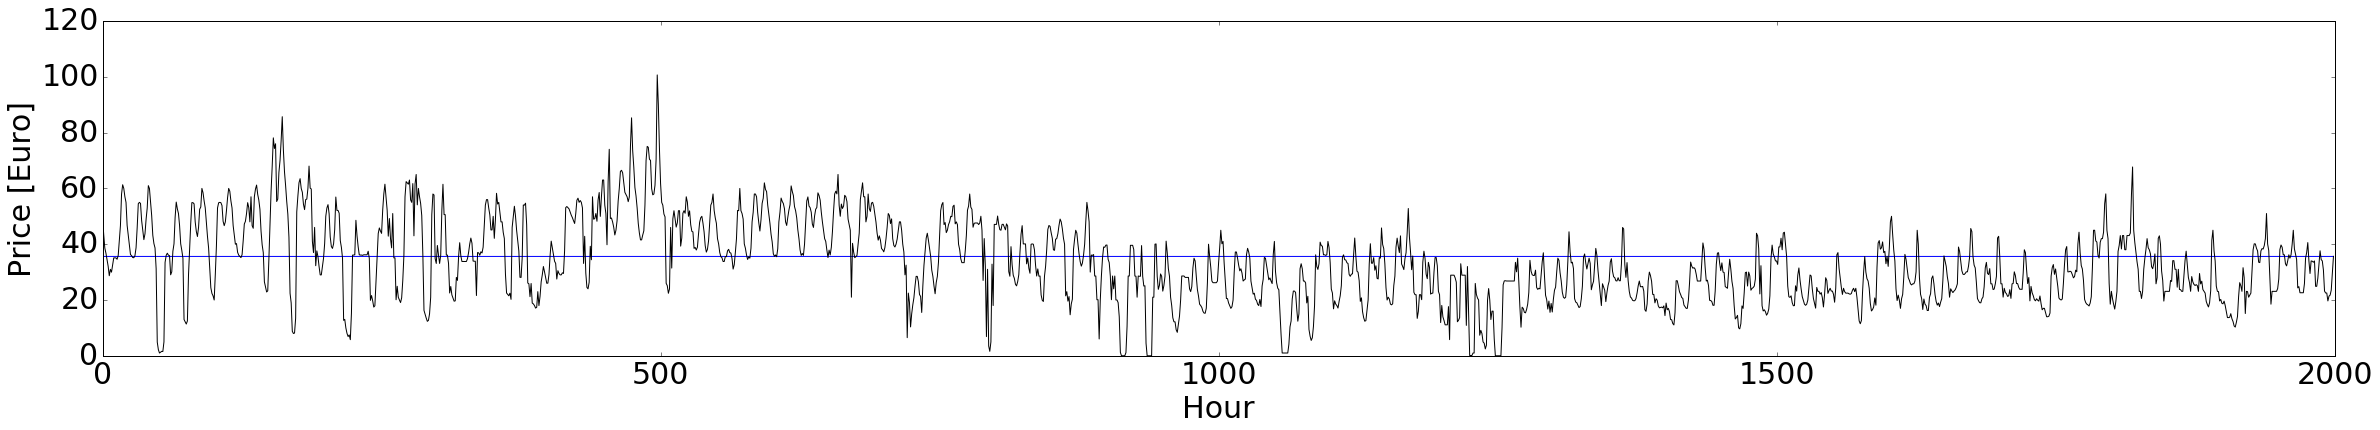

In [113]:
avg_model = AvgModel()
avg_model.fit(timestamp_weather_pucnik_2016_std, prices_2016)
plot_true_and_pred(avg_model, timestamp_weather_pucnik_2016_std, prices_2016, plot=True)

## Regularization NN - alpha

MLPRegressor and others use parameter alpha for L2 regularization.

In [ ]:
X_train = timestamp_weather_pucnik_demand_2016_std_sh_
y = prices_2016_sh_

In [104]:
neural_pucnik_100100100100 = MLPRegressor(hidden_layer_sizes=(100, 100, 100, 100),
                                          alpha = 0.00001)  # regularization
scores = cross_val_score(neural_pucnik_100100100100, X_train, y_train, 
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 29.68 (+/- 6.64)


In [102]:
neural_pucnik_100100100100 = MLPRegressor(hidden_layer_sizes=(100, 100, 100, 100),
                                          alpha = 0.0001)  # regularization
scores = cross_val_score(neural_pucnik_100100100100, X_train, y_train, 
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 27.27 (+/- 4.87)


In [99]:
neural_pucnik_100100100100 = MLPRegressor(hidden_layer_sizes=(100, 100, 100, 100),
                                          alpha = 0.001)  # regularization
scores = cross_val_score(neural_pucnik_100100100100, X_train, y_train, 
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 30.73 (+/- 5.78)


In [103]:
neural_pucnik_100100100100 = MLPRegressor(hidden_layer_sizes=(100, 100, 100, 100),
                                          alpha = 0.01)  # regularization
scores = cross_val_score(neural_pucnik_100100100100, X_train, y_train, 
                         cv=10, scoring='neg_mean_squared_error')
print("Accuracy: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

Accuracy: 30.62 (+/- 6.31)


### Plot prediction for 2017

In [56]:
consumption_2017 = load_power_consumption_2017(False)
tmp = Prices(consumption_2017[:, 1], consumption_2017[:, 0])
consumption_2017 = tmp.prices.astype(float)
# Combine demand with the 'previous' training data
timestamp_weather_pucnik_demand_2017 = np.column_stack((timestamp_weather_pucnik_2017_jan, consumption_2017))
# standardize
timestamp_weather_pucnik_demand_2017_std = std_demand.transform(timestamp_weather_pucnik_demand_2017)

Load 01 2017-Table 1.csv
Loading prices successful!


In [37]:
neural_pucnik_100100100100 = MLPRegressor(hidden_layer_sizes=(100, 100, 100, 100),
                                          alpha = 0.0001)  # regularization
neural_pucnik_100100100100.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100, 100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

Loss: 1279.81513536


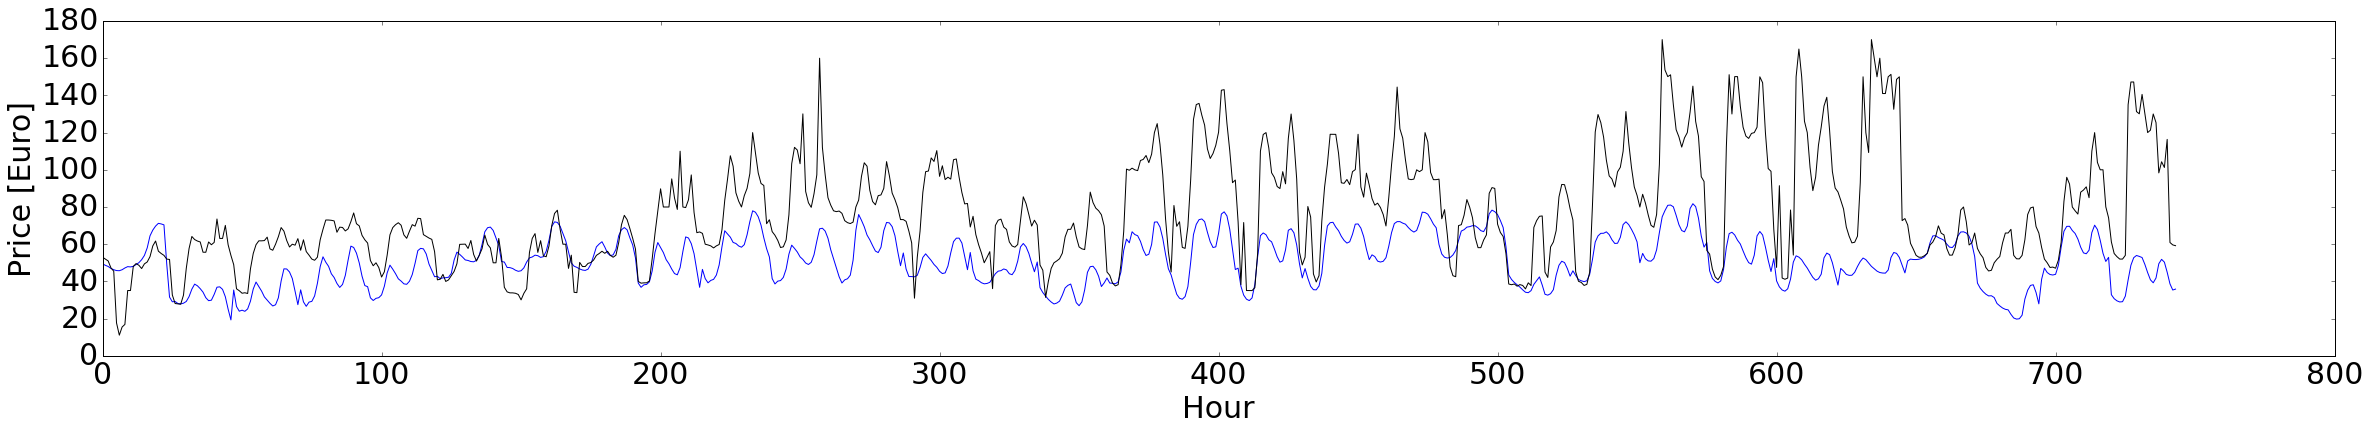

In [58]:
P = timestamp_weather_pucnik_demand_2017_std
true = raw_prices_2017_jan
plot_true_and_pred(neural_pucnik_100100100100, P, true, plot=True)